# Projet BIG DATA
POIRON Alex 23492 et THIL Tom 23034

## 1. Exploration : extract informations
## 2. Questions on the data
## 3. Moving average
## 4. Correlation between stocks
## 5. Return rate
## 6. More insights

In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#Manipulation to not confuse max() function from Python and max() function from Pyspark
to_exclude = ['max', 'sum']
from pyspark.sql.functions import *
for name in to_exclude:
    del globals()[name]

from pyspark.sql.functions import max as max_
from pyspark.sql.functions import sum as sum_

#Correlation imports
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import rcParams

import itertools
import requests

In [3]:
spark_application_name = "Projet"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

22/05/21 18:18:06 WARN Utils: Your hostname, alex-ASUS resolves to a loopback address: 127.0.1.1; using 192.168.1.26 instead (on interface wlp2s0)
22/05/21 18:18:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/21 18:18:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Exploration : exctract informations
### Lire les donnees et changement du schema
Nous allons créer des dataframe avec chaque dataset. Si on décide de le faire à la main, on le peut faire de cette manière :

In [4]:
amazon = spark.read.csv("./stocks_data/AMAZON.csv")
amazon.printSchema()
amazon.select('*').limit(10).show()
print("Number of rows =", amazon.count())

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+-------+-----------------+------------+
|       _c0|              _c1|              _c2|              _c3|              _c4|    _c5|              _c6|         _c7|
+----------+-----------------+-----------------+-----------------+-----------------+-------+-----------------+------------+
|      Date|             High|              Low|             Open|            Close| Volume|        Adj Close|company_name|
|2017-01-03| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100|753.6699829101562|      AMAZON|
|2017-01-04|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500|75

Il nous faut changer le schema egalement de ces dataframe pour que nous puissions mieux nous servir des donnees.

In [5]:
stocks_columns = [StructField("Date",TimestampType()), StructField("High",FloatType()), StructField("Low",FloatType()), StructField("Open",FloatType()),StructField("Close",FloatType()), StructField("Volume",FloatType()), StructField("Adj Close",FloatType()), StructField("company_name",StringType())]
new_schema = StructType(stocks_columns)

On remarque que l'on peut faire une fonction générique qui peut être appelée à chaque fois. Cela serait beucoup plus rapide si à chaque fois en plus de load le dataset, on souhaite avoir quelques informations dessus. C'est ce que nous allons faire maintenant.

In [6]:
def read_infos(path):
    """
        :param path : related path to the file
        :return the new DataFrame created
    """
    df_with_null = spark.read.csv(path, new_schema) #Creating the df with the new schema, we have a first null row
    df = spark.createDataFrame(df_with_null.tail(df_with_null.count()-1), df_with_null.schema) #With this line we delete it
    df.printSchema()
    df.show(40)
    print("Number of rows =", df.count())
    return df

In [7]:
df_amazon = read_infos('./stocks_data/AMAZON.csv')

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)



+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMAZON|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400.0|    795.9|      AMAZON|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800.0|   799.02|      AMAZON|
|2017-01-12 00:00:00|814.13| 799.5|800.31|813.64|4873900.0|   813.64|      AMAZON|
|2017-01-13 00:00:00|821.65| 811.4|814.32|817.14|3791900.0|   817.14|      AMAZON|
|201

In [8]:
df_apple = read_infos('./stocks_data/APPLE.csv')

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+-------+-------+-------+----------+---------+------------+
|               Date|   High|    Low|   Open|  Close|    Volume|Adj Close|company_name|
+-------------------+-------+-------+-------+-------+----------+---------+------------+
|2017-01-03 00:00:00|29.0825|  28.69|  28.95|29.0375|1.151276E8| 27.27764|       APPLE|
|2017-01-04 00:00:00|29.1275|28.9375|28.9625| 29.005| 8.44724E7|27.247108|       APPLE|
|2017-01-05 00:00:00| 29.215|28.9525|  28.98|29.1525| 8.87744E7|27.385668|       APPLE|
|2017-01-06 00:00:00|  29.54|29.1175| 29.195|29.4775|1.270076E8|27.690971|       APPLE|
|2017-01-09 00:00:00|29.8575| 29.485|29.4875|29.7475|1.342476E8|27.944603|    

In [9]:
df_fb = read_infos("./stocks_data/FACEBOOK.csv")

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|117.84|115.51|116.03|116.86|2.06639E7|   116.86|    FACEBOOK|
|2017-01-04 00:00:00|119.66|117.29|117.55|118.69|1.96309E7|   118.69|    FACEBOOK|
|2017-01-05 00:00:00|120.95|118.32|118.86|120.67|1.94922E7|   120.67|    FACEBOOK|
|2017-01-06 00:00:00|123.88|120.03|120.98|123.41|2.85453E7|   123.41|    FACEBOOK|
|2017-01-09 00:00:00|125.43|123.04|123.55| 124.9|2.28804E7|    124.9|    FACEBOOK|
|2017-01-10 00:00:00| 125.5|12

In [10]:
df_google = read_infos("./stocks_data/GOOGLE.csv")

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+-------+------+-------+---------+---------+------------+
|               Date|   High|    Low|  Open|  Close|   Volume|Adj Close|company_name|
+-------------------+-------+-------+------+-------+---------+---------+------------+
|2017-01-03 00:00:00| 789.63|  775.8|778.81| 786.14|1657300.0|   786.14|      GOOGLE|
|2017-01-04 00:00:00| 791.34| 783.16|788.36|  786.9|1073000.0|    786.9|      GOOGLE|
|2017-01-05 00:00:00| 794.48| 785.02|786.08| 794.02|1335200.0|   794.02|      GOOGLE|
|2017-01-06 00:00:00|  807.9|792.204|795.26| 806.15|1640200.0|   806.15|      GOOGLE|
|2017-01-09 00:00:00|809.966| 802.83| 806.4| 806.65|1274600.0|   806.65|      GOOGLE|
|2017-

In [11]:
df_microsoft = read_infos("./stocks_data/MICROSOFT.csv")

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-----+-----+-----+-----+---------+---------+------------+
|               Date| High|  Low| Open|Close|   Volume|Adj Close|company_name|
+-------------------+-----+-----+-----+-----+---------+---------+------------+
|2017-01-03 00:00:00|62.84|62.13|62.79|62.58|2.06941E7|58.673244|   MICROSOFT|
|2017-01-04 00:00:00|62.75|62.12|62.48| 62.3|  2.134E7|58.410725|   MICROSOFT|
|2017-01-05 00:00:00|62.66|62.03|62.19| 62.3| 2.4876E7|58.410725|   MICROSOFT|
|2017-01-06 00:00:00|63.15|62.04| 62.3|62.84|1.99229E7|58.917015|   MICROSOFT|
|2017-01-09 00:00:00|63.08|62.54|62.76|62.64|2.03827E7|58.729496|   MICROSOFT|
|2017-01-10 00:00:00|63.07|62.28|62.73|62.62| 1.8593E7|58.7107

In [12]:
df_tesla = read_infos('./stocks_data/TESLA.csv')

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|44.066|42.192|42.972|43.398|2.96165E7|   43.398|       TESLA|
|2017-01-04 00:00:00|  45.6|42.862| 42.95|45.398|5.60675E7|   45.398|       TESLA|
|2017-01-05 00:00:00|45.496| 44.39|45.284| 45.35|2.95585E7|    45.35|       TESLA|
|2017-01-06 00:00:00|46.062| 45.09|45.386|45.802|2.76395E7|   45.802|       TESLA|
|2017-01-09 00:00:00|46.384|  45.6|45.794|46.256|1.98975E7|   46.256|       TESLA|
|2017-01-10 00:00:00|  46.4|45

In [13]:
df_zoom = read_infos('./stocks_data/ZOOM.csv')

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+------+------+------+---------+---------+------------+
|               Date|   High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+-------+------+------+------+---------+---------+------------+
|2019-04-18 00:00:00|   66.0|60.321|  65.0|  62.0|2.57647E7|     62.0|        ZOOM|
|2019-04-22 00:00:00|   68.9| 59.94|  61.0|  65.7|9949700.0|     65.7|        ZOOM|
|2019-04-23 00:00:00| 74.169| 65.55| 66.87|  69.0|6786500.0|     69.0|        ZOOM|
|2019-04-24 00:00:00|   71.5| 63.16|  71.4|  63.2|4973500.0|     63.2|        ZOOM|
|2019-04-25 00:00:00|  66.85|  62.6| 64.74|  65.0|3863300.0|     65.0|        ZOOM|
|2019-04-26 00:00:00| 

On créé une variable globale qui va contenir tous nos DatFrame dans une liste

In [14]:
LIST_DF = [df_amazon, df_apple, df_fb, df_google, df_microsoft, df_tesla, df_zoom]

### Date period
Nous allons maintenant nous intéresser à la période qui s'écoule entre chaque observation de chaque DataFrame. Pour ce faire, nous allons faire une fonction qui en prenant un DataFrame en paramètre, retournera le type de période éecartant chaque observation. (jour le jour, quelques jours, semaines, ...)

In [15]:
def date_period(df):
    """
        :param df the DataFrame
        :return a string that correspond to the period in the DataFrame
    """
    diff = []
    name = df.first()["company_name"]
    dates = df.select('Date').rdd.flatMap(lambda x: x).collect()
    #Day case
    for i in range(0, len(dates)-1):
        diff.append(dates[i+1].day - dates[i].day)
    
    period = max(diff, key=diff.count)
    if period == 1 : 
        return "For " + name + ", it's a day period"
    
    #Month and year case
    diff = []
    for i in range(0, len(dates)-1):
        diff.append(dates[i+1].month - dates[i].month)
    period = max(diff, key=diff.count)
    
    if period == 1 : 
        return "For " + name + ", it's a month period"
    else: 
        return "For " + name + ", its a year period"        

In [16]:
for df in LIST_DF:
    print(date_period(df))

For AMAZON, it's a day period
For APPLE, it's a day period
For FACEBOOK, it's a day period
For GOOGLE, it's a day period
For MICROSOFT, it's a day period
For TESLA, it's a day period
For ZOOM, it's a day period


### Descriptive Statistics
Fonction permettant d'avoir certaines statistiques sur chaque colonne d'un dataframe (min, max, moyenne, variance)

In [17]:
def stats(df):
    """
        :param df : DataFrame
        :return Print mean, min, max, sd for each column of the DataFrame
    """
    columns = ["High", "Low", "Open", "Close", "Volume", "Adj Close"]
    
    for colname in columns:
        print("Stats for :", colname)
        df.agg(mean(df[colname]), min(df[colname]), max_(df[colname]), stddev(df[colname])).show()

In [18]:
stats(df_amazon)

Stats for : High
+------------------+---------+---------+-----------------+
|         avg(High)|min(High)|max(High)|stddev_samp(High)|
+------------------+---------+---------+-----------------+
|1762.0071216958152|   758.76|  3552.25| 667.238531575268|
+------------------+---------+---------+-----------------+

Stats for : Low
+------------------+--------+--------+----------------+
|          avg(Low)|min(Low)|max(Low)|stddev_samp(Low)|
+------------------+--------+--------+----------------+
|1722.1011452099956|   747.7| 3486.69|644.798809338276|
+------------------+--------+--------+----------------+

Stats for : Open
+-----------------+---------+---------+-----------------+
|        avg(Open)|min(Open)|max(Open)|stddev_samp(Open)|
+-----------------+---------+---------+-----------------+
|1743.433881363487|   757.92|   3547.0|657.1153070927141|
+-----------------+---------+---------+-----------------+

Stats for : Close
+------------------+----------+----------+------------------+
| 

### Check missing values
Fonction qui permet de verifier s'il y a des valeurs nulles dans chaque colonnes du DataFrame donnee en parametre.

In [19]:
def check_missing(df):
    """
        :param df : DataFrame
        :return : Show NULL values 
    """
    df.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in "timestamp"
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df.columns
]).show()

Nous verifions pour chaque dataframe

In [20]:
for df in LIST_DF:
    print("Missing values for each column of", df.first()["company_name"], "DataFrame")
    check_missing(df)

Missing values for each column of AMAZON DataFrame
+----+----+---+----+-----+------+---------+------------+
|Date|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+----+---+----+-----+------+---------+------------+
|   0|   0|  0|   0|    0|     0|        0|           0|
+----+----+---+----+-----+------+---------+------------+

Missing values for each column of APPLE DataFrame
+----+----+---+----+-----+------+---------+------------+
|Date|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+----+---+----+-----+------+---------+------------+
|   0|   0|  0|   0|    0|     0|        0|           0|
+----+----+---+----+-----+------+---------+------------+

Missing values for each column of FACEBOOK DataFrame
+----+----+---+----+-----+------+---------+------------+
|Date|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+----+---+----+-----+------+---------+------------+
|   0|   0|  0|   0|    0|     0|        0|           0|
+----+----+---+----+-----+------+---------+---

### Correlation
Pour chaque DataFrame, nous allons étudier les corrélations entre les données. Pour ce faire, nous allons changer le type des donées en **Vector** puis appliquer dessus une fonction du package **ML** de pyspark pour avoir la matrice de corrélation. Nous crééons donc une fonction générique qui prend en paramètre un DataFrame et qui retourne sa matrice de corrélation associée.

In [21]:
def get_corr_matrix(df):
    """
        :param df : DataFrame
        :return the correlation matrix of the DataFrame
    """
    vect_col = "corr_data"
    df = df.drop('Date','company_name') #Only numeric values
    assembler = VectorAssembler(inputCols=df.columns, outputCol=vect_col)
    df_vector = assembler.transform(df).select(vect_col)
    print(df.columns)

    #Transform dataframe matrix in list by getting its values
    matrix = Correlation.corr(df_vector, vect_col).collect()[0][0].toArray().tolist()
    return matrix

Maintenant que la fonction est faite, essayons de l'appliquer au dataset de Amazon. Pour faciliter la visualisation, on transforme la matrice en dataframe que l'on show par la suite.

In [22]:
matrix_amazon = get_corr_matrix(df_amazon)
amazon_num = df_amazon.drop('Date','company_name')
df_matrix = spark.createDataFrame(matrix_amazon,amazon_num.columns)
df_matrix.show()

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


22/05/21 18:18:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/21 18:18:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+-------------------+-------------------+------------------+-------------------+------------------+
|               High|                Low|               Open|             Close|             Volume|         Adj Close|
+-------------------+-------------------+-------------------+------------------+-------------------+------------------+
|                1.0| 0.9991960804346885| 0.9995248053674247|0.9994330757017126|0.16053643475450852|0.9994330757017126|
| 0.9991960804346885|                1.0|  0.999344391894671|0.9994769384519298|0.13293677767054252|0.9994769384519298|
| 0.9995248053674247|  0.999344391894671|                1.0|0.9988525402840831|0.14904748966416423|0.9988525402840831|
| 0.9994330757017126| 0.9994769384519298| 0.9988525402840831|               1.0| 0.1461794933995774|0.9999999999999999|
|0.16053643475450852|0.13293677767054252|0.14904748966416423|0.1461794933995774|                1.0|0.1461794933995774|
| 0.9994330757017126| 0.9994769384519298

### Visualisation
On se rend compte que même comme cela, c'est assez difficile de se visualiser nos résultats. Nous allons donc faire une fonction qui permet de visualiser nos matrices de corrélation.

In [23]:
def visualization_corr_matrix(corr_matrix,columns, name):
    """
        :param 
            - corr_matrix : correlation matrix
            - columns : numeric columns of the DataFrame
            - name : name of the DataFrame we are working with

        :return : Plotting the correlation matrix
    """
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)

    ax.set_title("Correlation Matrix for " + name)
    ax.set_xticklabels(['']+columns)
    ax.set_yticklabels(['']+columns)
    cax=ax.matshow(corr_matrix,cmap=cm.Pastel1)
    fig.colorbar(cax)

    plt.show()

Pour chaque DataFrame, on regarde donc sa matrice de corrélation

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


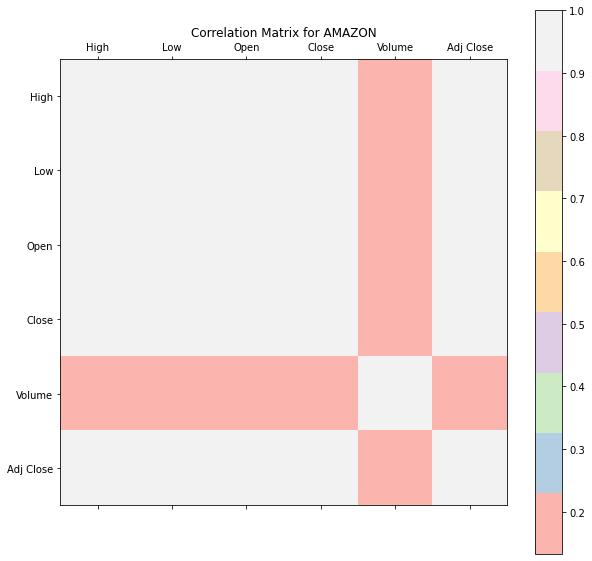

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


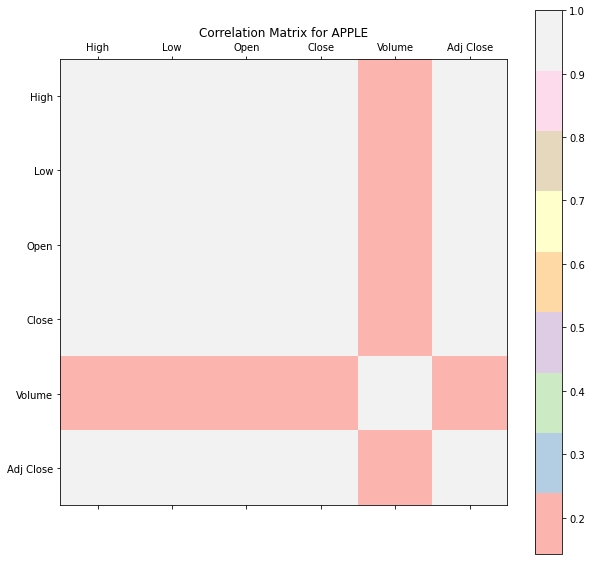

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


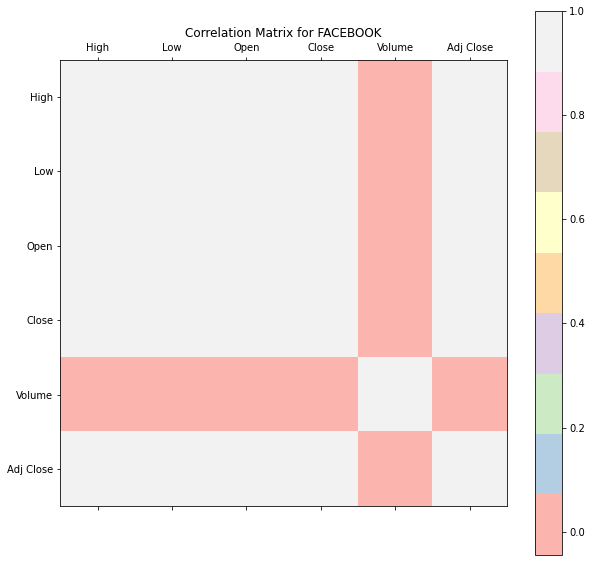

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


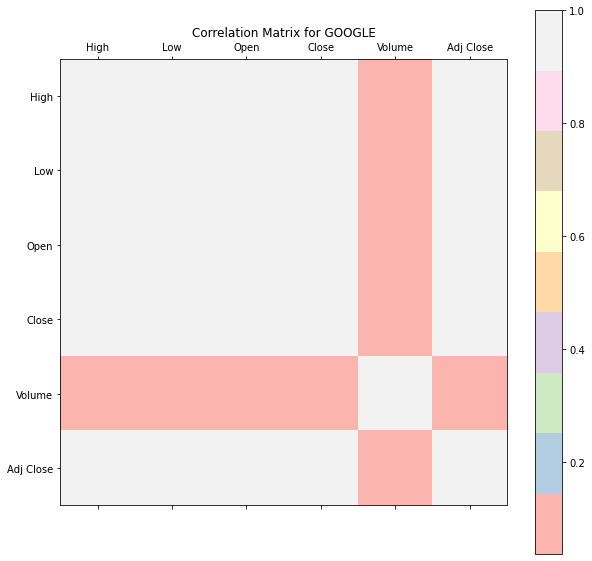

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


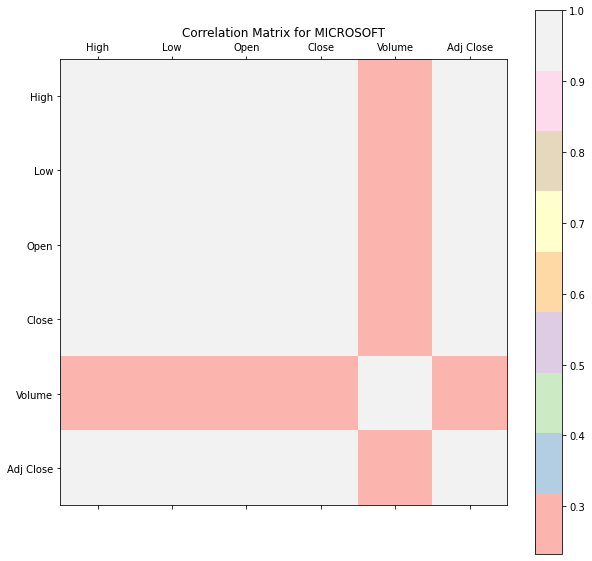

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


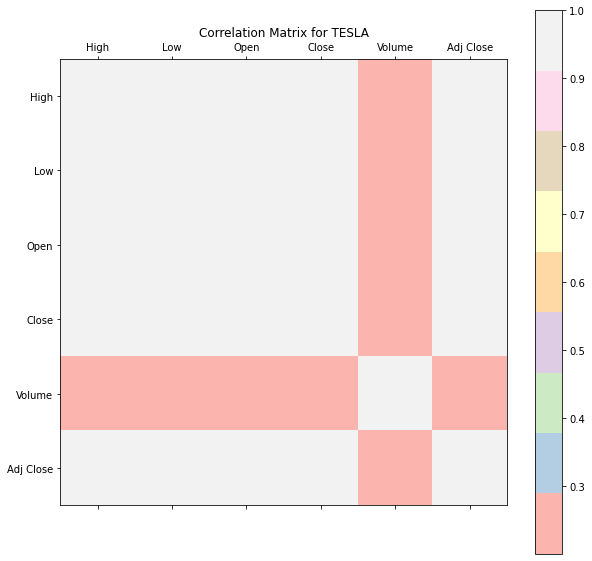

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


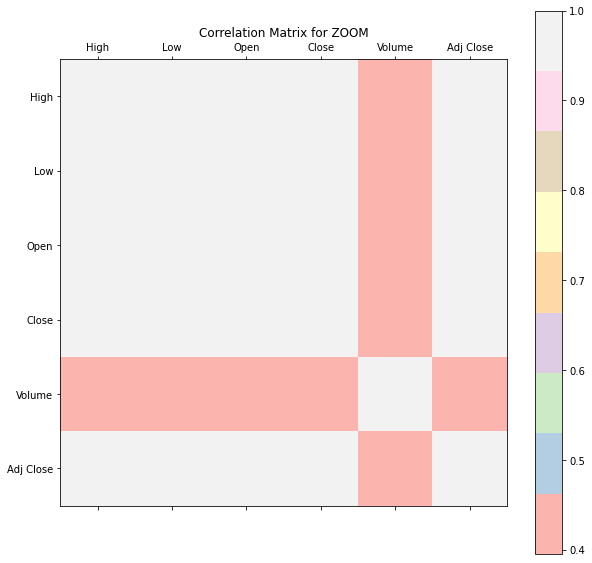

In [24]:
for df in LIST_DF:
    matrix = get_corr_matrix(df)
    name = df.first()['company_name']
    copy_num = df.drop('Date','company_name') # copy dataframe and drop non-numeric columns
    visualization_corr_matrix(matrix, copy_num.columns, name)

## 2. Questions on the data

- What is the average of the opening and closing prices for each stock price and for
different time periods (week, month, year)

On créé une fonction qui calcule la moyenne des prix selon une période précise. Pour nous aider, on créée également une fonction auxiliaire qui permet de construire une liste correspondant à la bonne temporalité demandée.

In [25]:
#Construct the list containing values foolowing the correct period
def get_list_period(df, w=False, m=False, y=False):
    """
        :param 
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
            - y : Boolean True if we want a year period, False otherwise

        :return : List containing date values corresponding to the period. 
            - [2017,2018,...] for years
            - [1, 2, 3, 4, ..., 12] for months
            - [1, 2, ..., 52] for weeks
    """
    list = []
    if w:
        dates = df.select(weekofyear(df['Date'])).collect()
        for i in range(len(dates)):
            if dates[i][0] not in list:
                list.append(dates[i][0])
    else:
        dates = df.select('Date').collect() #convert column to list
        for date in dates:
            if y:
                if date[0].year not in list:
                    list.append(date[0].year)
            else:
                if date[0].month not in list:
                    list.append(date[0].month)
    list.sort()
    return list

In [26]:
def average_price(df, w=False, m=False, y=False):
    """
        :param 
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
            - y : Boolean True if we want a year period, False otherwise

        :return : Show average for opening and closing price calculated following the period choose
            - if year -> [2017, 2018, ...] -> average open and close price for 2017, 2018, ...
            - if month -> [1, 2, ...] -> average open and clos eprice for 1, 2, 3, ...
            - if week -> [1, 2, ..., 52] -> average open and clos eprice for 1, 2, 3, ..., 52
    """
    list_period = get_list_period(df, w, m, y)
    for i in list_period:
        #Filter the Dataframe following the period choose
        if y: df_filtered = df.filter(year(df['Date']) == i)
        elif m: df_filtered = df.filter(month(df['Date']) == i)
        else: df_filtered = df.filter(weekofyear(df['Date']) == i)
        
        print("Average open price and close price in", i)
        df_filtered.agg(mean(df_filtered['Open']), mean(df_filtered['Close'])).show()

In [27]:
for df in LIST_DF:
    print("Average price for each year of", df.first()['company_name'])
    average_price(df, y=True)

Average price for each year of AMAZON
Average open price and close price in 2017
+----------------+-----------------+
|       avg(Open)|       avg(Close)|
+----------------+-----------------+
|968.275618959708|968.1670116409363|
+----------------+-----------------+

Average open price and close price in 2018
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|1644.0727091633466|1641.7261758629545|
+------------------+------------------+

Average open price and close price in 2019
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|1788.7461896623884|1789.189206077939|
+------------------+-----------------+

Average open price and close price in 2020
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|2636.5054538710433|2636.649604240712|
+------------------+-----------------+

Average pri

Afin de faciliter la visibilite de ces informations, nous faisons une fonction de visualisation pour **l'average_price** sur la periode d'annee, de mois ou de semaine.

In [28]:
def plot_avg_price(df, w=False, m=False, y=False):
    """
        :param 
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
            - y : Boolean True if we want a year period, False otherwise
        
        :return : Plotting the results obtained by the function avg_price for each DataFrame
    """
    
    
    #Construct list of y axis that is period scale (year, week or month)
    list_period = get_list_period(df, w, m, y)
    avg_open = []
    avg_close = []
    #Construct lists for average open and close prices
    for i in list_period:
        if y: df_filtered = df.filter(year(df['Date']) == i)
        elif m: df_filtered = df.filter(month(df['Date']) == i)
        else: df_filtered = df.filter(weekofyear(df['Date']) == i)

        avg_open.append(df_filtered.agg(mean(df_filtered['Open'])).collect()[0][0])
        avg_close.append(df_filtered.agg(mean(df_filtered['Close'])).collect()[0][0])

    #Create bars
    x = np.arange(len(list_period))  
    fig, ax = plt.subplots(figsize=(10,10))
    width = 0.4
    open_bar = ax.bar(x - width/2, avg_open, width, label='Open price')
    close_bar = ax.bar(x + width/2, avg_close, width, label='Close price')

    #Legend
    name = df.first()['company_name']
    ax.set_ylabel('Average for open price and close price')
    ax.set_title('Average by prices for ' + name)
    ax.set_xticks(x, list_period)
    ax.legend()

    ax.bar_label(open_bar, padding=3)
    ax.bar_label(close_bar, padding=3)

    plt.show()




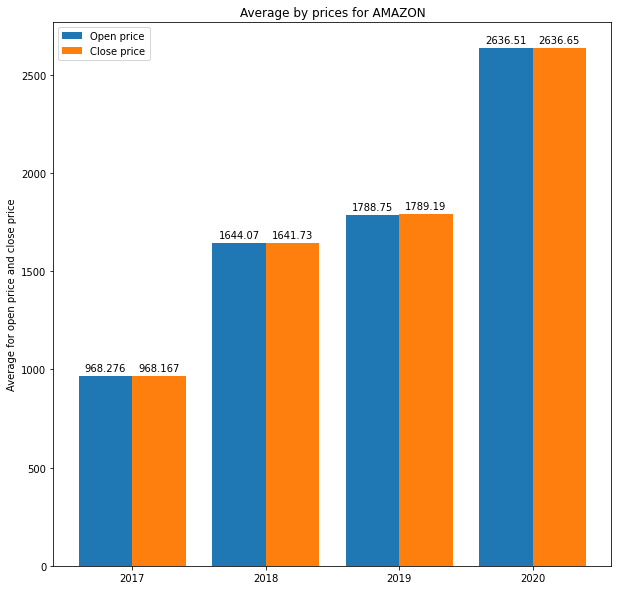

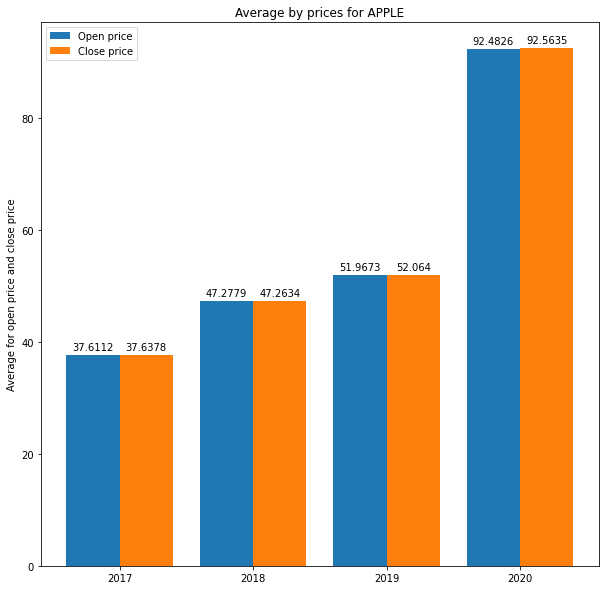

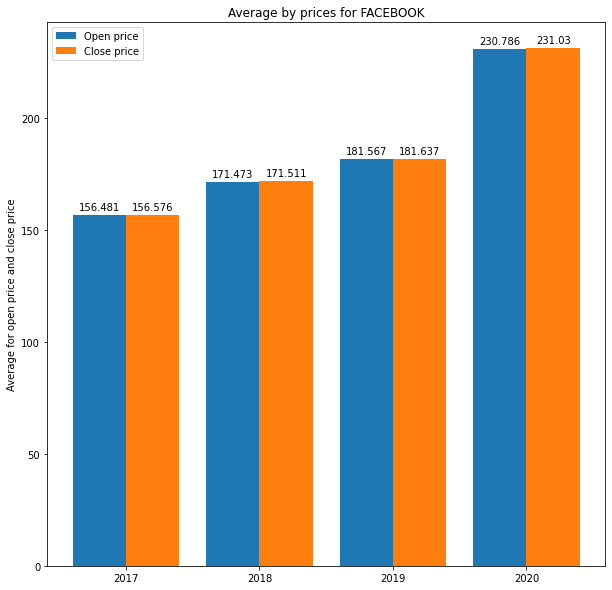

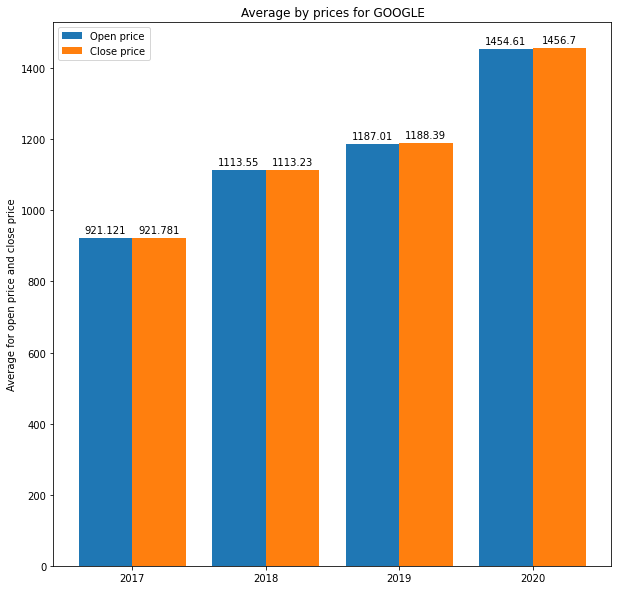

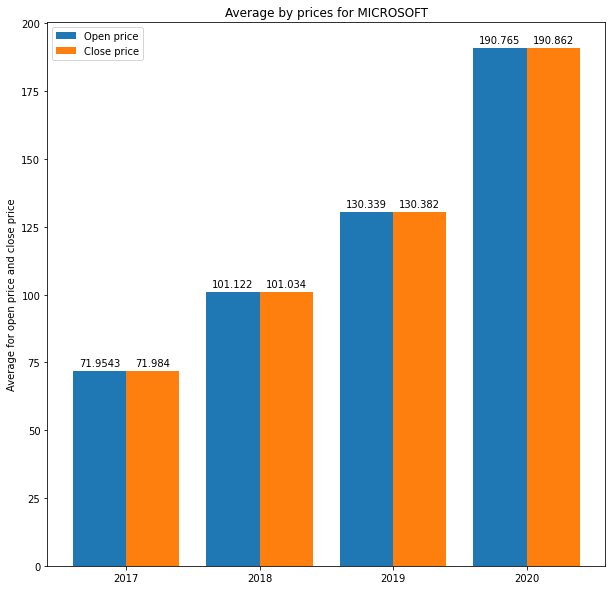

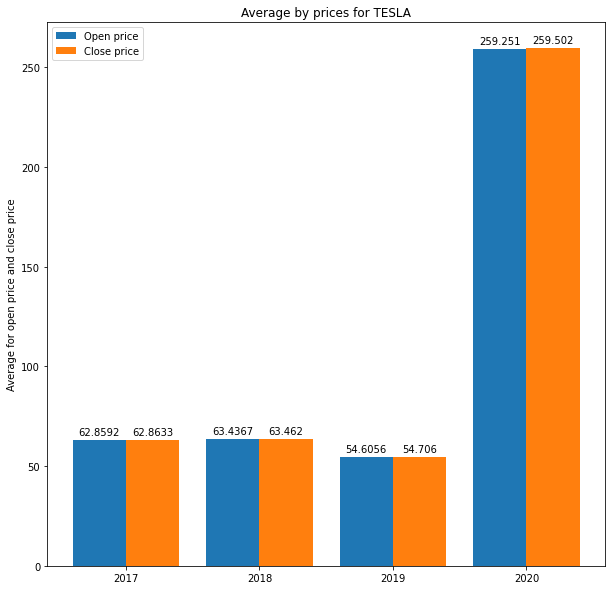

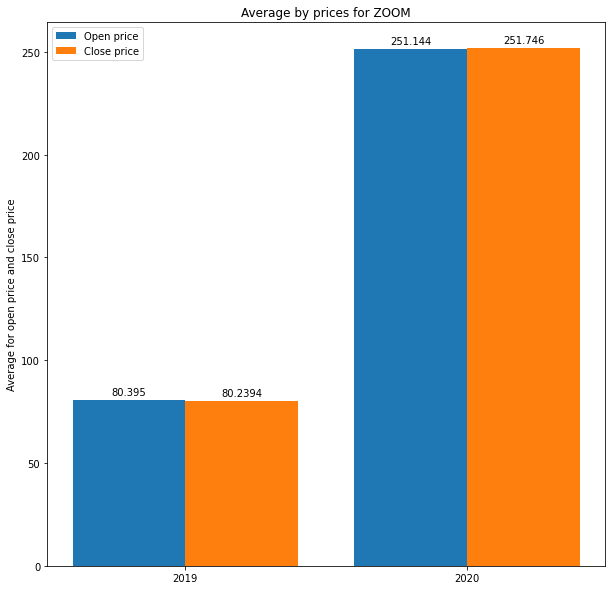

In [29]:
for df in LIST_DF:
    plot_avg_price(df,y=True)

- How do the stock prices change day to day and month to month (may be you can
create new columns to save those calculations)

Fonction qui permet de visualiser les différents prix d'une certaine action soit au jours le jour ou chaque mois 

In [30]:
def plot_evolution_stock_prices(df, d=False,m=False):
    """
        :param 
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
        
        :return Plotting evolution for each price for each DataFrame following a 
                specific period(each month or day to day). 
                For each DataFrame, we have a subplot with all prices except Volume price and another 
                subplot with Volume price. This separation is caused by the values of Volume price 
                that are higher than other prices
    """
    #Construct list of y axis that is period scale (year, week or month)
    period = []
    if d:
        dates = df.select(dayofyear(df['Date'])).collect()
        for i in range(len(dates)):
                period.append(dates[i][0])
    else:
        dates = df.select('Date').collect() #convert column to list
        for date in dates:
            if date[0].month not in period:
                period.append(date[0].month)
    
    if m: period.sort() #sort for months not for days
    
    #Lists for all prices except volume
    avg_open = []
    avg_close = []
    avg_high = []
    avg_low = []
    avg_adj_close = []
    prices = [
        (avg_open, "Open"),
        (avg_close, "Close"),
        (avg_high, "High"),
        (avg_low, "Low"),
        (avg_adj_close, "Adj CLose")
        ]
    
    avg_volume = []

    #Construct lists
    for i in period:
        if m: df_filtered = df.filter(month(df['Date']) == i)
        else: df_filtered = df.filter(dayofyear(df['Date']) == i)

        for (price, name_price) in prices:
            price.append(df_filtered.agg(mean(df_filtered[name_price])).collect()[0][0])
        
        avg_volume.append(df_filtered.agg(mean(df_filtered['Volume'])).collect()[0][0])

    
    #PLotting
    name = df.first()['company_name']
    x = np.arange(len(period))
    figure, axis = plt.subplots(1, 2, figsize=(10,7))
    
    #First plot for al prices except volume due to the diffence in values
    for (price, name_price) in prices:
        axis[0].plot(x, price, label=name_price)

    axis[0].set_title('Average by prices except Volume one for ' + name)
    axis[0].set_xlabel("Period of time")
    axis[0].set_ylabel('Average for all prices')
    axis[0].legend()

    #2d plot for volume prices
    axis[1].plot(x, avg_volume, label="Volume price")
    axis[1].set_title('Average for Volume price for ' + name)
    axis[1].legend()
    axis[1].set_xlabel('Period of time')
    

    plt.show()

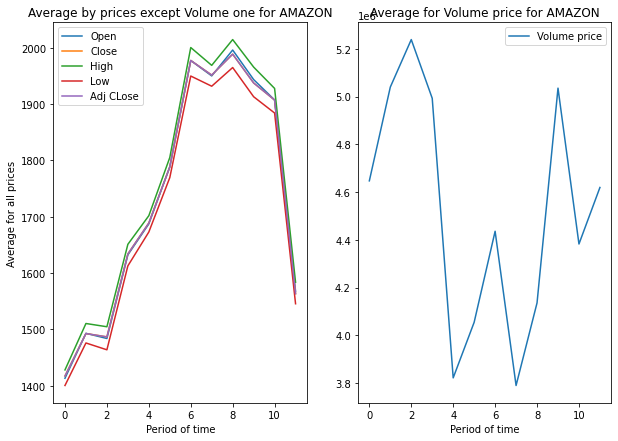

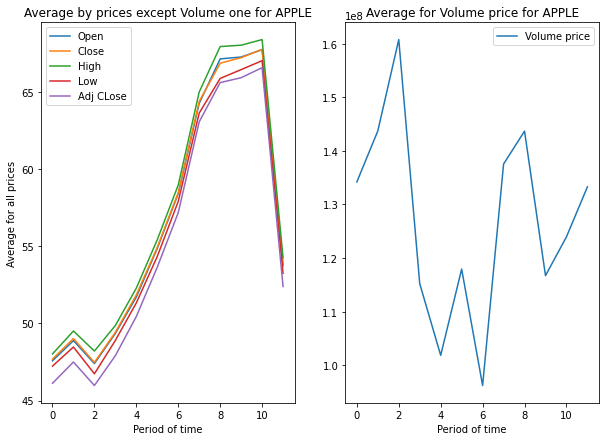

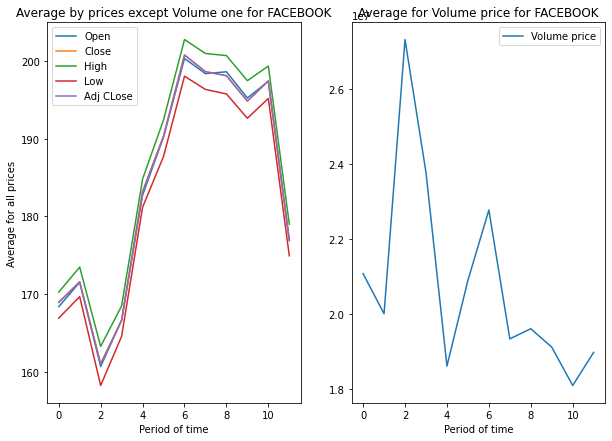

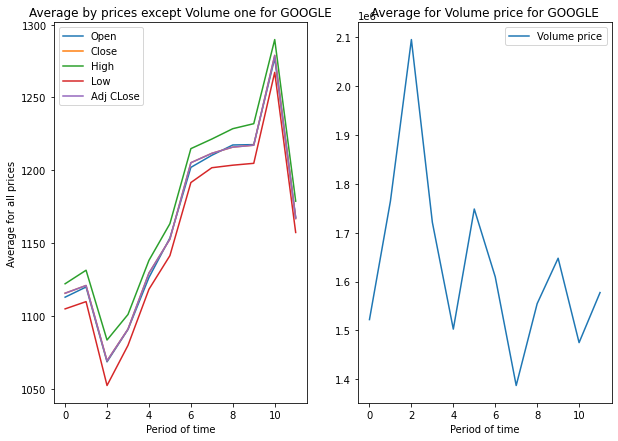

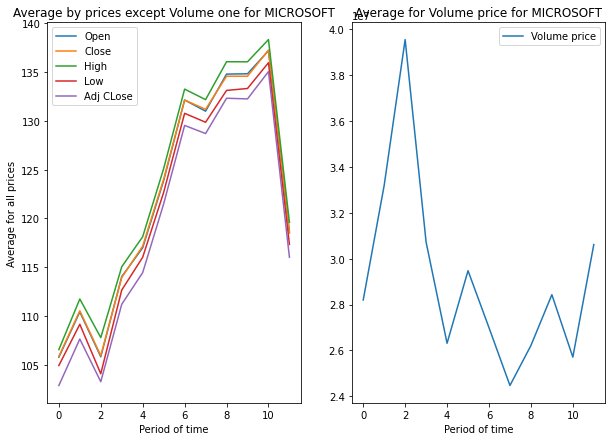

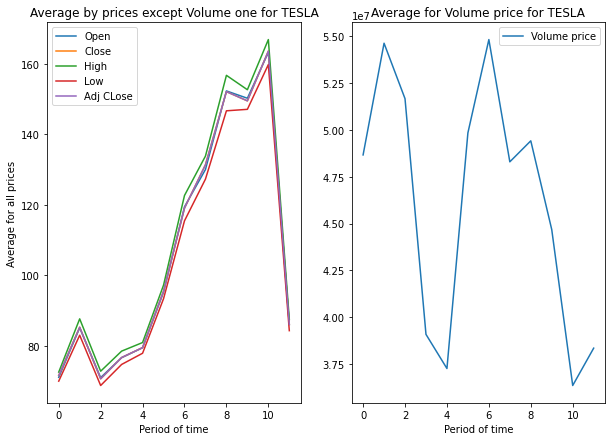

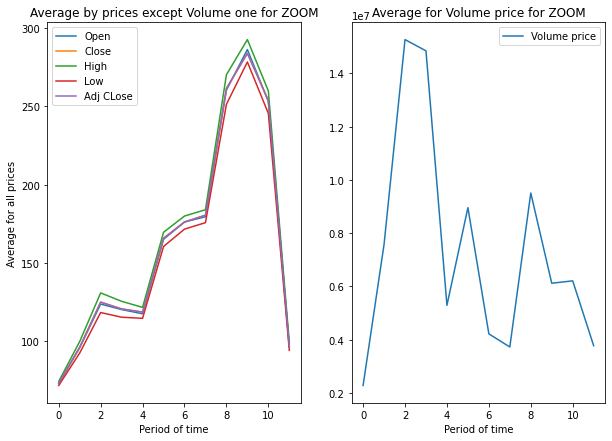

In [31]:
for df in LIST_DF:
    plot_evolution_stock_prices(df,m=True)

- Based on the opening and closing price, calculate the daily return of each stock

In [32]:
def daily_return(df):
    """
        :param df : Dataframe
        :return add in a column the daily return calculated day to day
    """
    df.withColumn("evolution_price", df['Close'] - df['Open']).show()

In [33]:
for df in LIST_DF:
    print(df.first()['company_name'])
    daily_return(df)

AMAZON
+-------------------+------+------+------+------+---------+---------+------------+---------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|evolution_price|
+-------------------+------+------+------+------+---------+---------+------------+---------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|          -4.25|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|      -1.210022|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|      18.900024|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|      13.630005|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMAZON|     -1.0800171|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400.0|    795.9|      AMAZON|     -0.6999512|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800.0|   799.02|      AMAZON|      5.3600464|
|20

+-------------------+------+------+-----+-----+---------+---------+------------+---------------+
|               Date|  High|   Low| Open|Close|   Volume|Adj Close|company_name|evolution_price|
+-------------------+------+------+-----+-----+---------+---------+------------+---------------+
|2019-04-18 00:00:00|  66.0|60.321| 65.0| 62.0|2.57647E7|     62.0|        ZOOM|           -3.0|
|2019-04-22 00:00:00|  68.9| 59.94| 61.0| 65.7|9949700.0|     65.7|        ZOOM|       4.699997|
|2019-04-23 00:00:00|74.169| 65.55|66.87| 69.0|6786500.0|     69.0|        ZOOM|      2.1299973|
|2019-04-24 00:00:00|  71.5| 63.16| 71.4| 63.2|4973500.0|     63.2|        ZOOM|      -8.200001|
|2019-04-25 00:00:00| 66.85|  62.6|64.74| 65.0|3863300.0|     65.0|        ZOOM|     0.26000214|
|2019-04-26 00:00:00| 66.99|  63.6|66.12|66.22|1527400.0|    66.22|        ZOOM|    0.099998474|
|2019-04-29 00:00:00|  68.5| 64.75|66.53|68.17|1822300.0|    68.17|        ZOOM|      1.6399994|
|2019-04-30 00:00:00| 72.52| 6

- What are the stocks with the highest daily return

In [34]:
def highest_daily_return():
    """
        :return : the highest daily return
    """
    maxi = 0
    for df in LIST_DF:
        tmp = df.agg(max_(df['Close'] - df['Open'])).collect()[0][0]
        name_tmp = df.first()['company_name']
        if (tmp > maxi): 
            maxi = tmp
            name = name_tmp

    print("Highest daily return is :",maxi ,"found in", name)

In [35]:
highest_daily_return()

Highest daily return is : 196.64013671875 found in AMAZON


- Calculate the average daily return for different periods (week, month, and year)

In [36]:
def avg_daily_return(df, w=False, m=False, y=False):
    """
        :param
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
            - y : Boolean True if we want a year period, False otherwise

        :return Average daily return calculated following the perdio choose
    """
    list = []
    if w:
        dates = df.select(weekofyear(df['Date'])).collect()
        for i in range(len(dates)):
            if dates[i][0] not in list:
                list.append(dates[i][0])
    else:
        dates = df.select('Date').collect() #convert column to list
        for date in dates:
            if y:
                if date[0].year not in list:
                    list.append(date[0].year)
            else:
                if date[0].month not in list:
                    list.append(date[0].month)

    list.sort()

    for i in list:
        if y: df_filtered = df.filter(year(df['Date']) == i)
        elif m: df_filtered = df.filter(month(df['Date']) == i)
        else: df_filtered = df.filter(weekofyear(df['Date']) == i)
        print("Average daily return in", i)
        df_filtered.agg(mean(df_filtered['Close']- df_filtered['Open'])).show()

In [37]:
for df in LIST_DF:
    print("Average daily return for each year of", df.first()['company_name'])
    avg_daily_return(df_amazon, y=True)

Average daily return for each year of AMAZON
Average daily return in 2017
+--------------------+
| avg((Close - Open))|
+--------------------+
|-0.10860731877178785|
+--------------------+

Average daily return in 2018
+-------------------+
|avg((Close - Open))|
+-------------------+
|-2.3465333003921813|
+-------------------+

Average daily return in 2019
+-------------------+
|avg((Close - Open))|
+-------------------+
|0.44301641555059523|
+-------------------+

Average daily return in 2020
+-------------------+
|avg((Close - Open))|
+-------------------+
| 0.1441503696687232|
+-------------------+

Average daily return for each year of APPLE
Average daily return in 2017
+--------------------+
| avg((Close - Open))|
+--------------------+
|-0.10860731877178785|
+--------------------+

Average daily return in 2018
+-------------------+
|avg((Close - Open))|
+-------------------+
|-2.3465333003921813|
+-------------------+

Average daily return in 2019
+-------------------+
|avg((Clos

## Moving Average

Fonction qui calcule le moving average à selon une certaine periode

In [69]:
#date_begin format : yyyy-mm-dd
def moving_average(df, column_name, period):
    """
        :param 
            - df : the DataFrame
            - column_name : specific price
            - period : Number of days for each period
    """
    list_SMA = []
    for i in range (0, df.count(), period):
        df_filtered = spark.createDataFrame(df.collect()[i:(i+period)])
        sma = df_filtered.agg(mean(df_filtered[column_name])).collect()[0][0]
        list_SMA.append(sma)
    return list_SMA

def visualization_moving_average(column_name, period):
    figure, axes = plt.subplots(1, figsize=(15,10))
    for dfs in LIST_DF:
        sma = moving_average(dfs, column_name, period)
        label = "SMA for "+ dfs.first()['company_name']
        axes.plot(sma, label=label)
        title = "SMA for "+ column_name + " price"
        axes.set_title(title)
        axes.legend()
    plt.show()

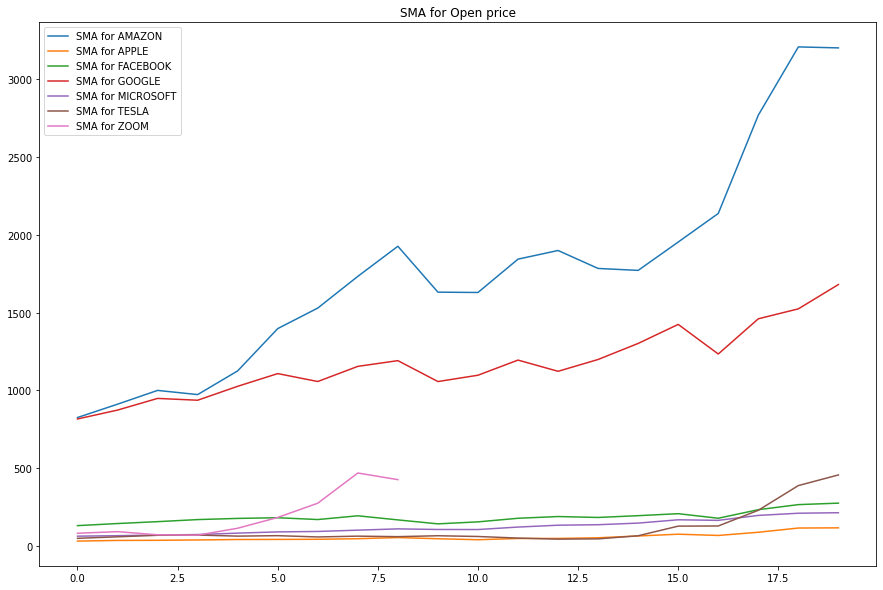

In [70]:
visualization_moving_average('Open', 50)

## Correlation between stocks

On créé une première fonction qui va merge 2 dataframes pour avoir les colonnes numériques de 2 stocks. Par la suite on créé la matrice de corrélation de ce nouveau dataframe en utilisant la fonction faite précédemment

In [40]:
def merge(df1, df2):
    """
        :param :
            - df1 : first dataframe
            - df2 : second dataframe
    
        :return : join the two dataframe with only numerics values
    """
    stocks1 = df1.drop('Date', 'company_name')
    stocks2 = df2.drop('Date', 'company_name')
    stocks2_rename = stocks2.toDF(*(c+"_2" for c in stocks2.columns))
    return stocks1.join(stocks2_rename)

Nous allons tester cette fonction sur toutes les combinaisons possibles de nos différents dataframes.

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


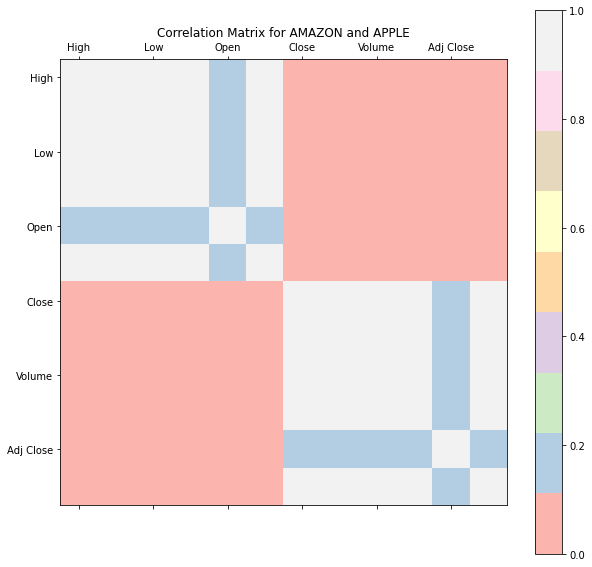

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


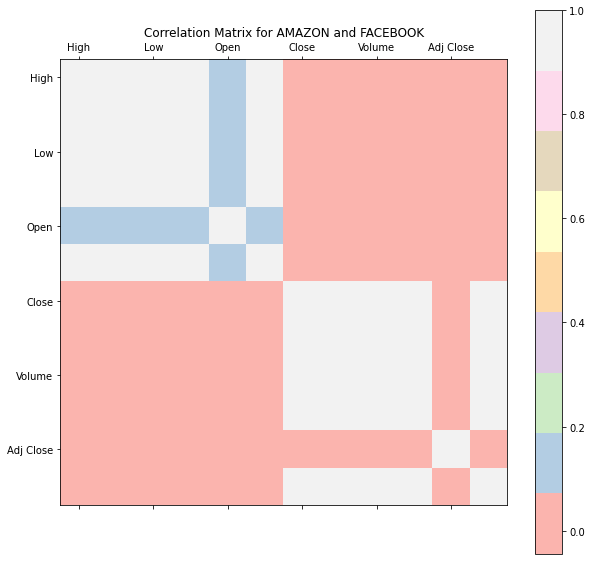

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


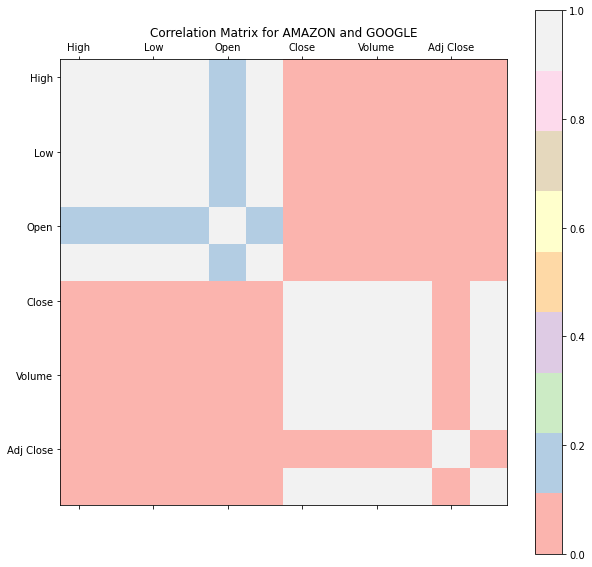

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


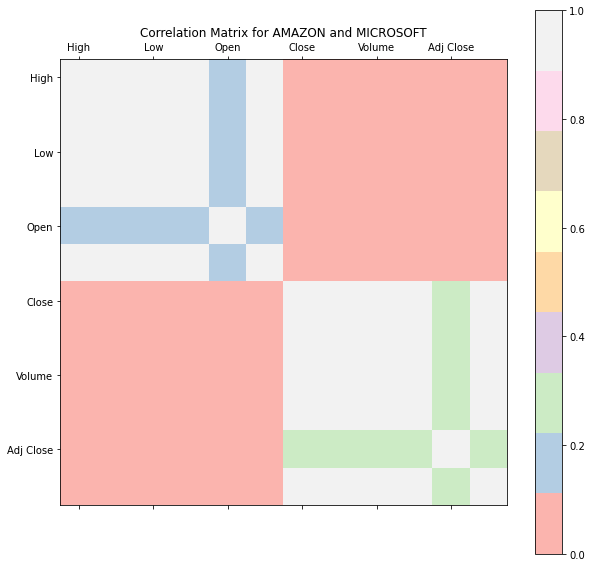

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


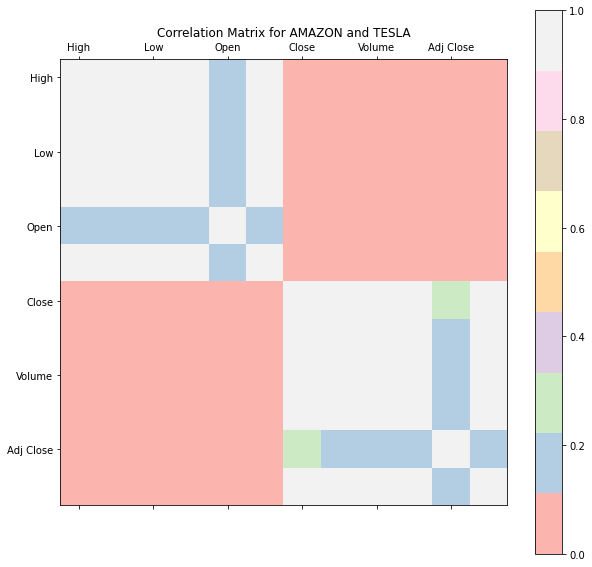

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


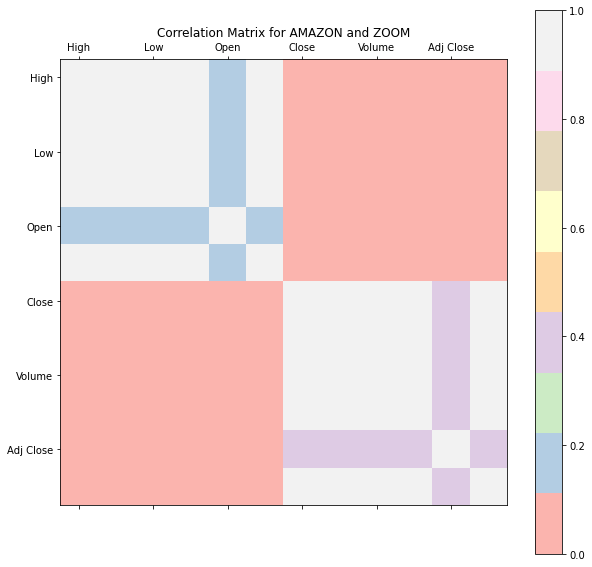

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


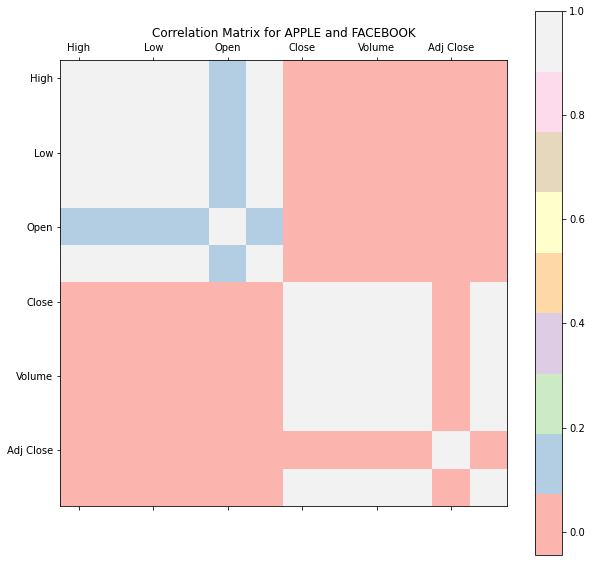

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


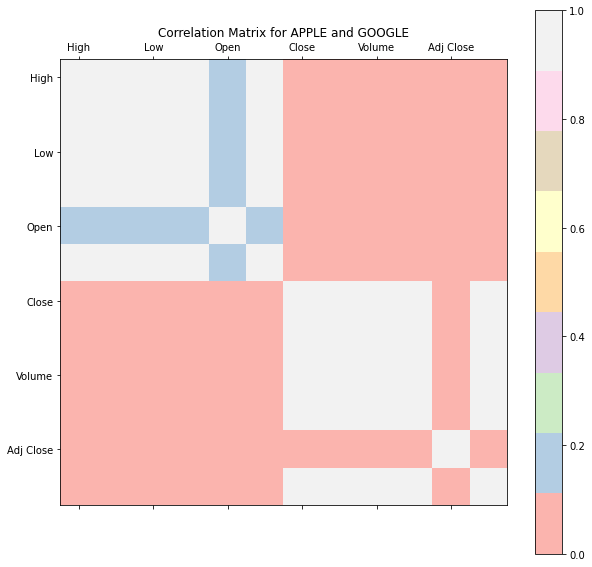

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


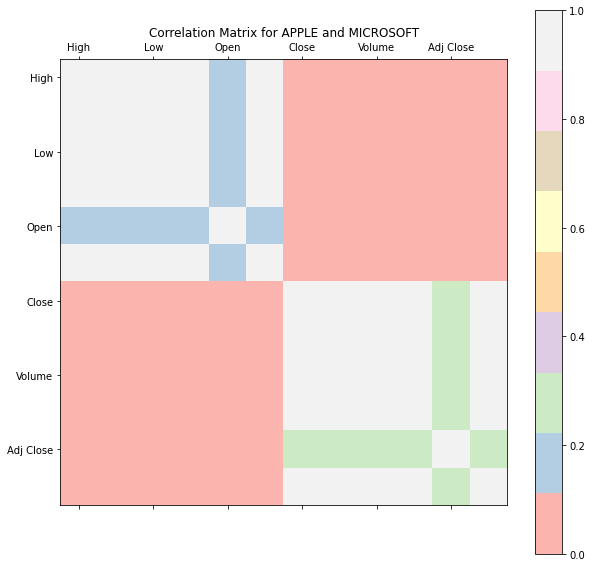

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


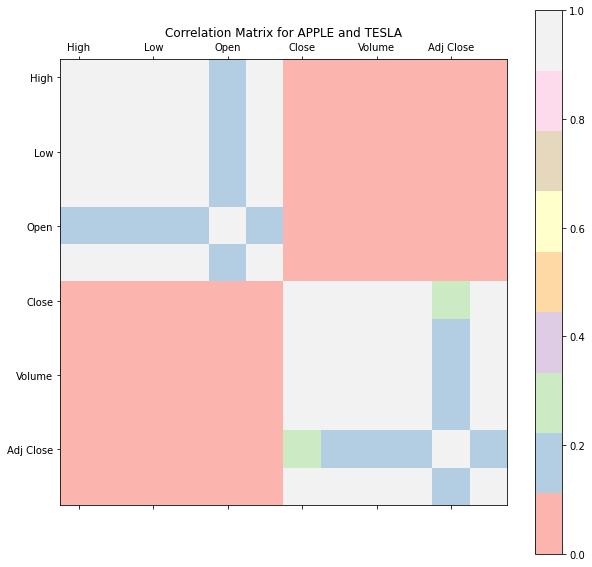

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


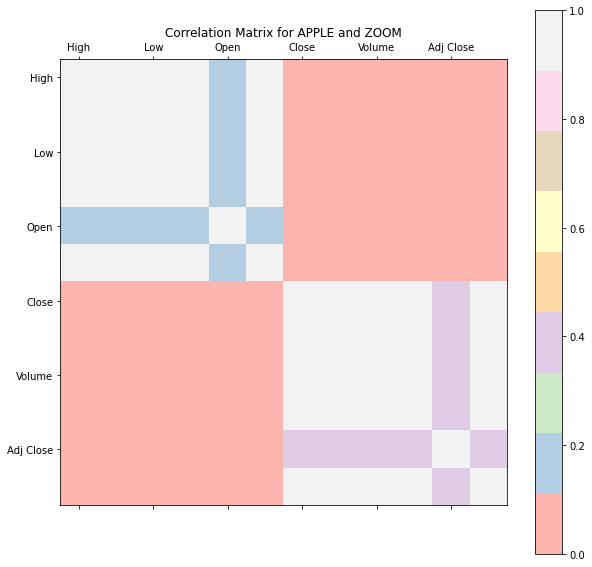

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


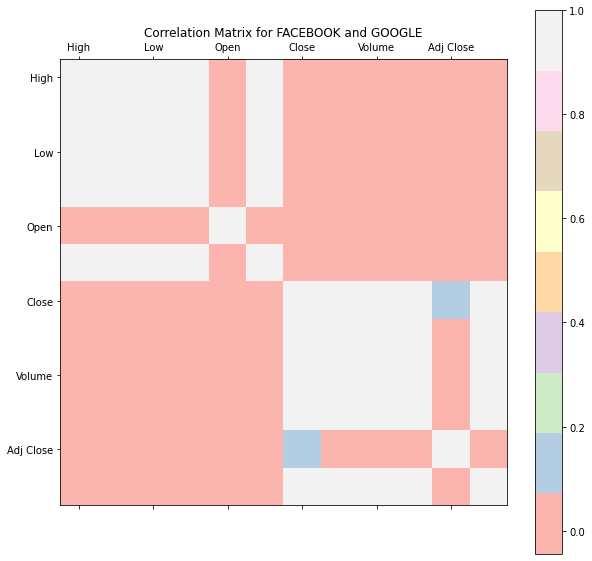

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


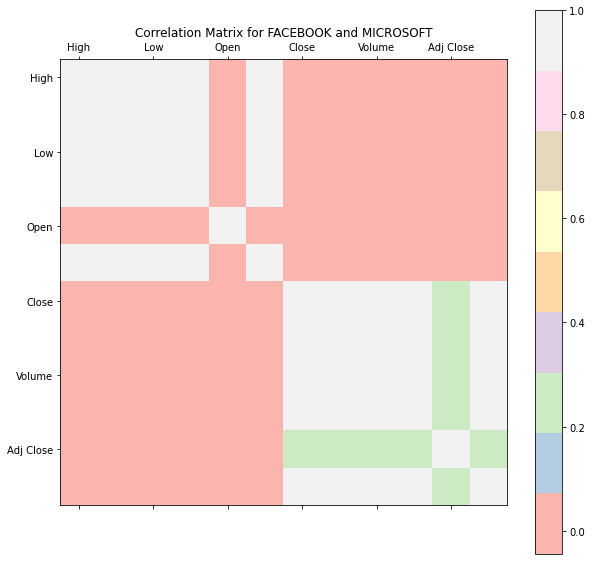

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


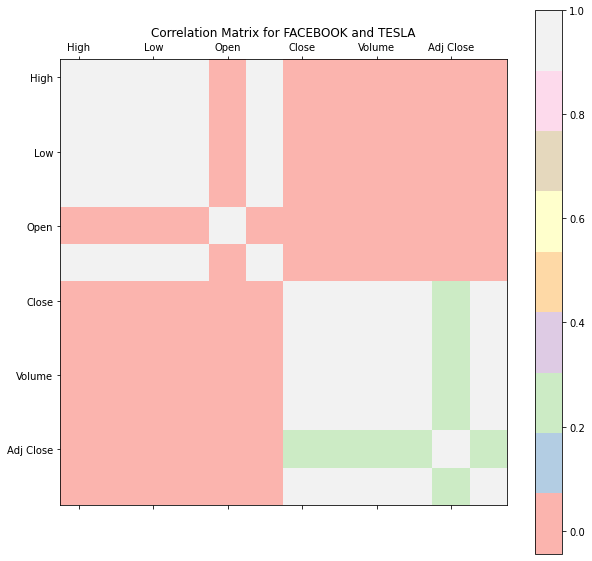

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


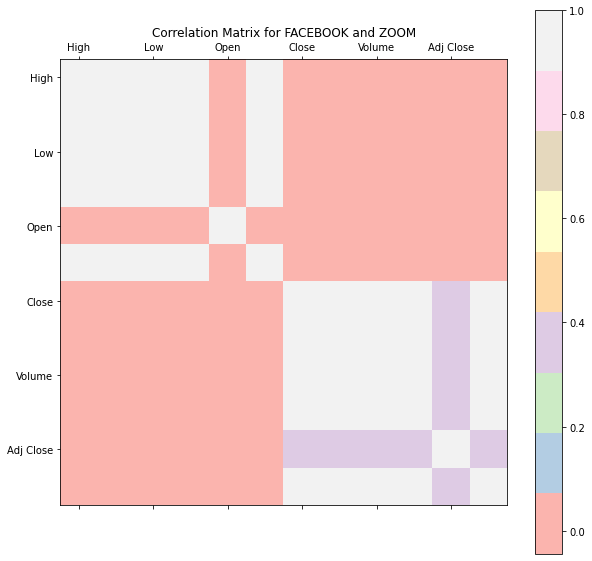

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


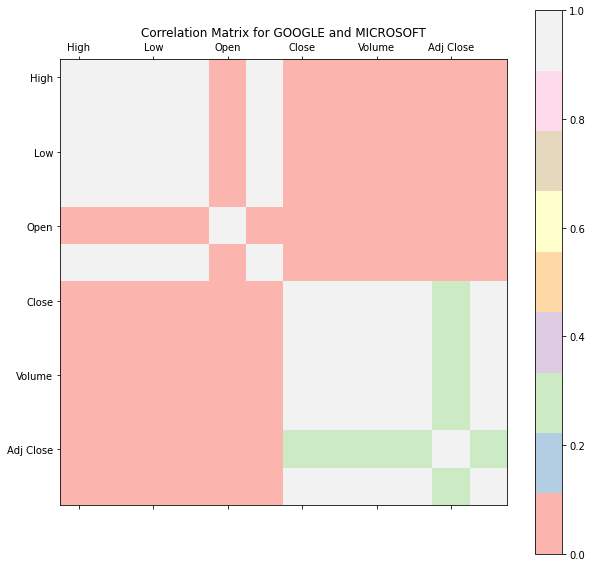

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


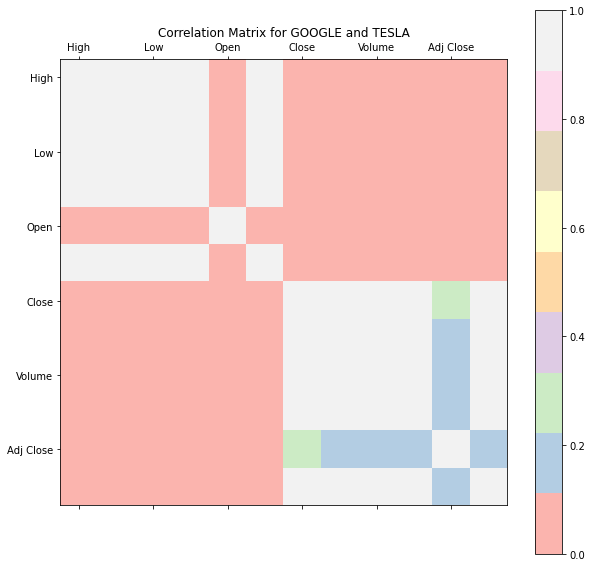

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


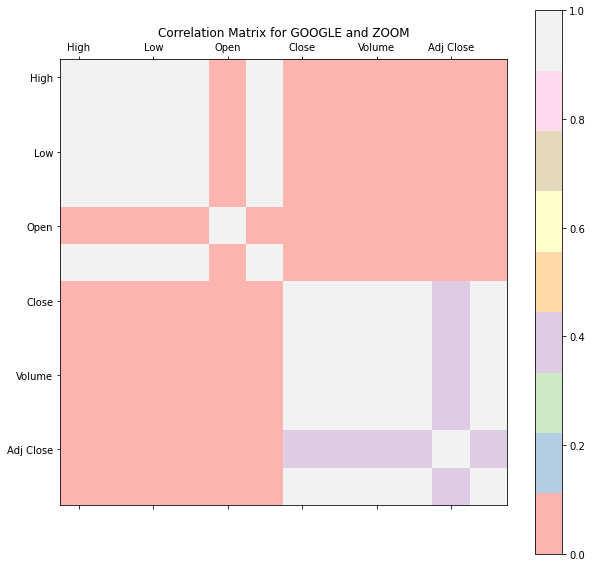

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


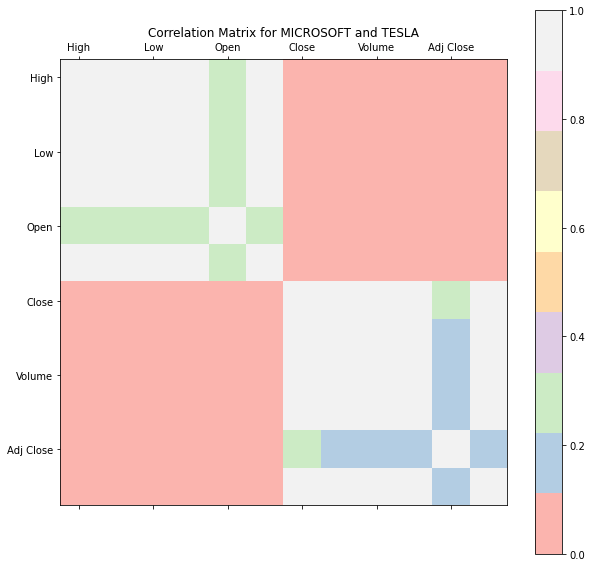

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


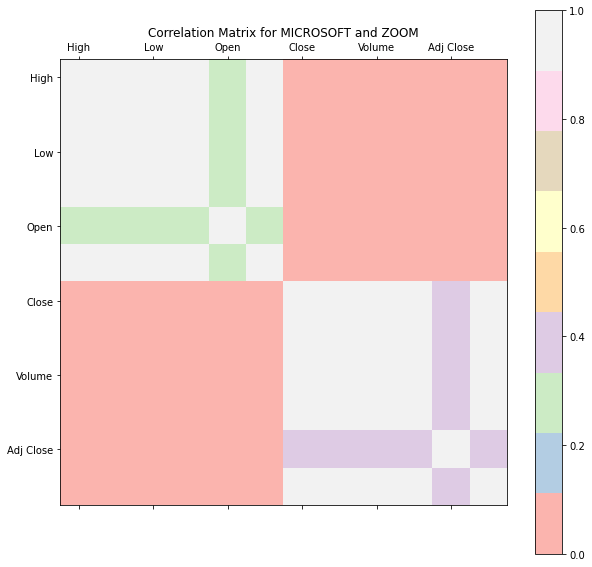

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


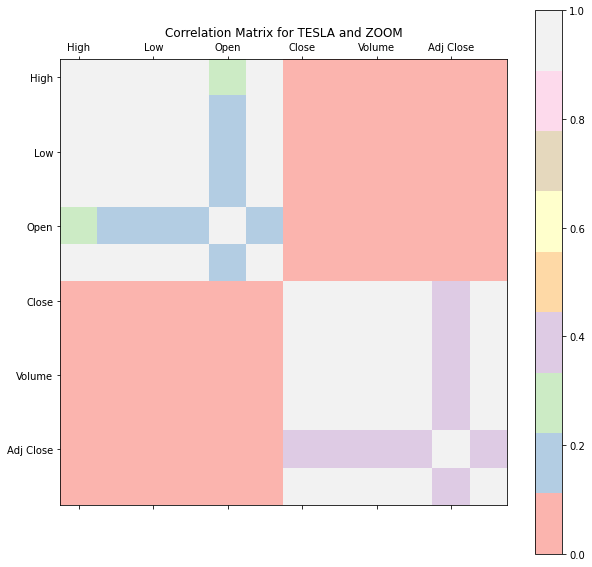

In [41]:
for (df1,df2) in itertools.combinations(LIST_DF, 2):
    df_merged = merge(df1,df2)
    mat = get_corr_matrix(df_merged)
    final_name = df1.first()['company_name'] + " and " + df2.first()['company_name']
    visualization_corr_matrix(mat,df_merged.columns, final_name)

## Return Rate

Fonction qui permet d'avoir le return rate en fonction d'une période. Prenons un exemple :

- Si l'on souhaite calculer le return rate sur 1 mois, alors on calcule la différence entre le close price du fin du mois et l'open price du premier jour du mois. A cette différence, on la soustrait par la valeur initiale du début du mois. On pultiplie le tout par 100 pour avoir un pourcentage. 
- Formule : (end_value - init_value)/ init_value * 100

In [42]:
def return_rate(df, w=False, m=False, y=False):
    """
        :param 
            - df : DataFrame
            - w : Boolean True if we want a week period, False otherwise
            - m : Boolean True if we want a month period, False otherwise
            - y : Boolean True if we want a year period, False otherwise

        :return the return_rate following a specific period
    """
    list_period = get_list_period(df, w, m, y)

    for i in list_period:
        if y: df_filtered = df.filter(year(df['Date']) == i)
        elif m: df_filtered = df.filter(month(df['Date']) == i)
        else: df_filtered = df.filter(weekofyear(df['Date']) == i)
        
        print("Average return rate in", i)
        init_value = df_filtered.collect()[0]['Open']
        end_value = df_filtered.collect()[-1]['Close']
        return_rate = ((end_value - init_value) / init_value) * 100
        print("Return rate in ", i, "is " + str(return_rate)+"%")

Nous testons notre fonction pour le return rate de chaque dataframe sur chaque année

In [43]:
for df in LIST_DF:
    print("The return rate for each year for", df.first()['company_name'])
    return_rate(df, y=True)
    print("-------------------------")

The return rate for each year for AMAZON
Average return rate in 2017
Return rate in  2017 is 54.29992572735133%
Average return rate in 2018
Return rate in  2018 is 28.154434360334896%
Average return rate in 2019
Return rate in  2019 is 26.115207985258248%
Average return rate in 2020
Return rate in  2020 is 71.38338541666667%
-------------------------
The return rate for each year for APPLE
Average return rate in 2017
Return rate in  2017 is 46.139888832213806%
Average return rate in 2018
Return rate in  2018 is -7.299011460770763%
Average return rate in 2019
Return rate in  2019 is 89.58615472504773%
Average return rate in 2020
Return rate in  2020 is 64.94640262601172%
-------------------------
The return rate for each year for FACEBOOK
Average return rate in 2017
Return rate in  2017 is 52.08136565571764%
Average return rate in 2018
Return rate in  2018 is -26.221295733000723%
Average return rate in 2019
Return rate in  2019 is 59.12085530601625%
Average return rate in 2020
Return ra

## More Insights
### MACD (Moving Average Convergence and Divergence)
On va créer une fonction qui nous calcul la MACD. Il nout faut 3 valeurs :
- MACD = EMA12 - EMA26
- SIGNAL = EMA9(MACD)
- Difference = MACD - SIGNAL

Pour chaquie MACD, il nous faut calculer l'EMA et non la SMA, ce qui nous oblige à faire une nouvelle fonction.
Une complète analyse représente la visualisation de ces 3 courbes en plus de celle du prix que l'on souhaite observer.

Ici, on a les valeurs 12, 26 et 9 qui sont des valeurs basiques qui ont été mises en référence dans ces fonctions. Bien sur, il est évident que l'on peut prendre des périodes différentes selon le besoin.

In [44]:
def exponential_moving_average(df, column_name, period, smooth=2):
    """
        :param
            - df : dataframe
            - column_name : specific price
            - period :  period time selected
            - smooth : smoothness use in the formula (usually 2)

        :return the exponential moving average for a specific price on a specific period of time
    """
    prices = df.select(column_name).rdd.flatMap(lambda x: x).collect()
    ema = [sum(prices[:period]) / period]
    
    for price in prices[period:]:
        ema.append((price * (smooth / (1 + period))) + ema[-1] * (1 - (smooth / (1 + period))))
    
    return ema

In [45]:
def get_MACD(df, column_name, period1=12, period2=26, smooth=2):
    """
        :param 
            - df : the DataFrame
            - column_name : specific price
            - period1 : used to calculate first EMA (usually 12)
            - period2 : used to calculate second EMA (usually 26)
            - smooth : (usually 2) -> used in formula to get the EMA

        :return the MACD calculated with the formula : MACD =  EMA(period1) - EMA(period2)
    """
    sma_26 = exponential_moving_average(df, column_name, period2, smooth)
    sma_12 = exponential_moving_average(df, column_name, period1, smooth)
    diff = len(sma_12) - len(sma_26)
    sma_12 = sma_12[:-diff]
    sma_12 = np.array(sma_12)
    sma_26 = np.array(sma_26)
    return list(np.subtract(sma_12, sma_26))


def get_signal(macd, signal_period=9, smooth=2):
    """
        :param
            - macd : MACD calculated previously
            - signal_period : period used to calculate the EMA of the signal(usually 9)
            - smooth : (usually 2) -> used in formula to get the EMA

        :return the EMA of the MACD calculated before -> called the signal
    """
    df_macd = spark.createDataFrame([float(x) for x in macd], FloatType())
    signal = exponential_moving_average(df_macd, "value", signal_period, smooth)
    return signal

def visualization_MACD(df, column_name, period1=12, period2=26, signal_period=9, smooth=2):
    """
        :param
            - df : the DataFrame
            - column_name : specific price
            - period1 : used to calculate first EMA (usually 12)
            - period2 : used to calculate second EMA (usually 26)
            - signal_period : period used to calculate the EMA of the signal(usually 9)
            - smooth : (usually 2) -> used in formula to get the EMA

        :return : Visualization of a specific price in constrast with both MACD and signal curves calculated.

    """
    #Get MACD and SIGNAL
    macd = get_MACD(df, column_name, period1, period2, smooth)
    signal = get_signal(macd,signal_period, smooth)

    figure, axes = plt.subplots(2,1, figsize=(15,10))
    
    #Create linspace for MACD and SIGNAL to facilitate the vizualisation
    x_macd = np.linspace(0, len(df.select(column_name).rdd.flatMap(lambda x: x).collect()), num=len(macd))
    x_signal = np.linspace(0, len(df.select(column_name).rdd.flatMap(lambda x: x).collect()), num=len(signal))
    
    #Plotting MACD
    axes[1].plot(x_macd, macd, label='MACD', c='g')
    axes[1].plot(x_signal, signal, label='Signal', c='r')
    axes[1].set_xlabel("Period of time (day to day)")
    axes[1].set_ylabel("Value")
    title = "MACD of the " + column_name + " price"
    axes[1].set_title(title)
    axes[1].legend()
    
    #Plotting normal price
    label = column_name + " price"
    axes[0].plot(df.select(column_name).rdd.flatMap(lambda x: x).collect(), label=label)
    title = column_name + " price"
    axes[0].set_title(title)
    axes[0].set_xlabel("Period of time (day to day)")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    

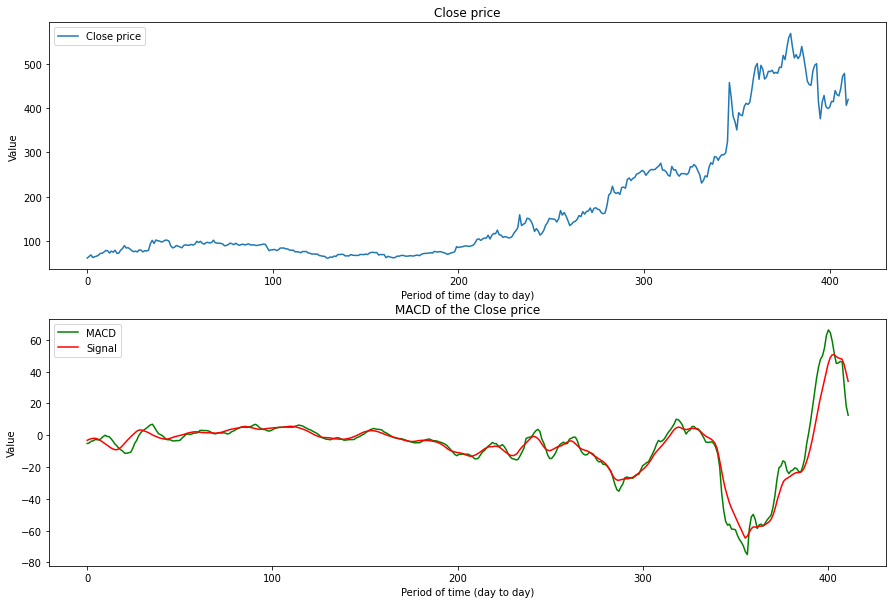

In [46]:
visualization_MACD(df_zoom, "Close")

### Aroon Oscillator

Cette fois-ci, nous allons voir ce qu'est le Aroon Oscillator. Le Aroon oscillator est la différence entre deux indicateurs qui sont le Aroon up et le Aroon down. Pour calculer toutes ces valeurs, on utilise les formules suivantes :
- Arron up = [ 25 - nb_period avec nouveau High] / 25 * 100
- Arron down = [ 25 - nb_period avec nouveau Low] / 25 * 100
  
Ensuite, nous n'avons plus au'a **plot** cette courbe.

In [47]:
def count_days(high, low):
    """
        :param
            - high : list of high price
            - low : list of low price

        :return (count_high, count_low) : time with a new high price reached and a new low price reached
    """
    count_high = 1
    count_low = 1
    for i in range(len(high)-1):
        if high[i+1] > high[i]: #New High reached
            break
        else:
            count_high += 1
    
    for i in range(len(low)-1):
        if low[i+1] < low[i]: #New Low reached
            break
        else:
            count_low += 1

    return count_high, count_low

def get_aroon_indicators(df, period=25):
    """
        :param
            - df : the Dataframe
            - period : number used for the formula (usually 25)
        
        :return (aroon_up, aroon_down) : two indicators for aroon oscillator
    """
    aroon_up = []
    aroon_down = []
    for i in range (0, df.count(), period):
        df_filtered = spark.createDataFrame(df.collect()[i:(i+period)])
        high = df_filtered.select("High").rdd.flatMap(lambda x : x).collect()
        low = df_filtered.select("Low").rdd.flatMap(lambda x : x).collect()
        
        count_high, count_low = count_days(high, low)
        aroon_up.append((period - count_high) / period * 100)
        aroon_down.append((period - count_low) / period * 100)

    return aroon_up, aroon_down

In [48]:
def plot_aroon_oscillator(df, period=25):
    """
        :param
            - df : the DataFrame
            - period : number used for the formula to calculate the Aroon indicators (usually 25)
        
        :return : Plot the Aroon Oscillator calculated in comparisation with usually the closing price
    """
    #Get Aroon indicators and create Aroon Oscillator
    aroon_up, aroon_down = np.array(get_aroon_indicators(df, period))
    aroon_oscillator = list(np.subtract(aroon_up, aroon_down))
    
    figure, axes = plt.subplots(2,1, figsize=(15,10))
    x_aroon = np.linspace(0, len(df.select("High").rdd.flatMap(lambda x: x).collect()), num=len(aroon_up))

    #Plotting Aroon up and Aroon down
    axes[1].plot(x_aroon, aroon_oscillator, label='Aroon OSCILLATOR', c='r')
    axes[1].set_xlabel("Period of time (day to day)")
    axes[1].set_ylabel("Value")
    title = "AROON " + str(period)
    axes[1].set_title(title)
    axes[1].legend()
    
    #Plotting normal price
    axes[0].plot(df.select("Close").rdd.flatMap(lambda x: x).collect(), label="Closing price")
    axes[0].set_title("Closing price")
    axes[0].set_xlabel("Period of time (day to day)")
    axes[0].set_ylabel("Value")
    axes[0].legend()

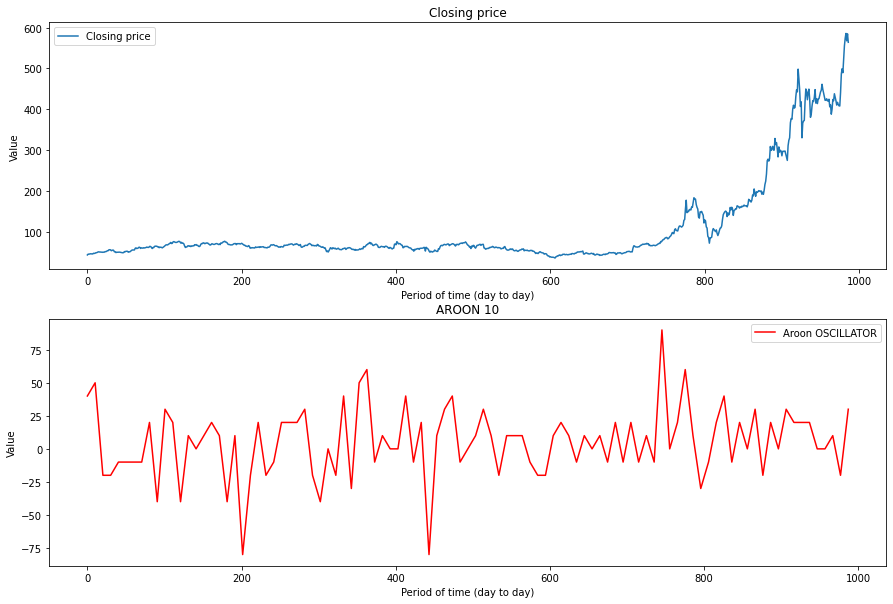

In [49]:
plot_aroon_oscillator(df_tesla, 10)

### Bollinger Bands
Pour faire les bandes de Bollinger, nous devons dans un premier temps calculer la SMA (Simple Moving Average) ainsi que la std selon une periode precise. Avec ces deux valeurs, on créé donc les deux bandes de Bollinger que l'on compare avec les valeurs normales du prix.

In [85]:
def get_SMA(df, column_name, period):
    """
        :param 
            - df : the DataFrame
            - column_name : 
            - period : period used to calculate the SMA
        
        :return list_SMA : the SMA calculated
    """
    list_SMA = []
    for i in range (0,df.count(), period):
        df_filtered = spark.createDataFrame(df.collect()[i:(i+period)])
        sma = df_filtered.agg(mean(df_filtered[column_name])).collect()[0][0]
        list_SMA.append(sma)

    return list_SMA

def get_std(df, column_name, period):
    """
        :param 
            - df : the DataFrame
            - column_name : 
            - period : period used to calculate the SMA
        
        :return list_std : the std calculated
    """
    list_std = []
    for i in range (0,df.count(), period):
        df_filtered = spark.createDataFrame(df.collect()[i:(i+period)])
        std = df_filtered.agg(stddev(df_filtered[column_name])).collect()[0][0]
        list_std.append(std)

    return list_std

def get_bollinger_bands(df, column_name, period):
    """
        :param 
            - df : the DataFrame
            - column_name : 
            - period : period used to calculate the SMA
        
        :return (bollinger_up, bollinger_down) : 2 curves that form the bollinger bands
    """
    sma = np.array(get_SMA(df,column_name, period))
    std = np.array(get_std(df,column_name,period))
    
    bollinger_up = sma + std * 2 
    bollinger_down = np.subtract(sma, std*2)

    return bollinger_up, bollinger_down

def plot_bollinger_bands(df, column_name, period):
    """
        :param 
            - df : the DataFrame
            - column_name : 
            - period : period used to calculate the SMA
        
        :return : Plot the Bolligner bands with the specific price we want
    """
    #Get Bollinger Bands
    bollinger_up, bollinger_down = get_bollinger_bands(df, column_name, period)

    #Create linspace for both bands fot the vizualisation
    x_bollinger_up = np.linspace(0, len(df.select(column_name).rdd.flatMap(lambda x: x).collect()), num=len(bollinger_up))
    x_bollinger_down = np.linspace(0, len(df.select(column_name).rdd.flatMap(lambda x: x).collect()), num=len(bollinger_down))

    figure, axes = plt.subplots(1, figsize=(15,10))

    #Plotting Bollinger Bands
    axes.plot(x_bollinger_up,bollinger_up, label='Bollinger Up', c='g')
    axes.plot(x_bollinger_down,bollinger_down, label='Bollinger Down', c='r')
    
    #Plotting the specific price with its name
    label = column_name + " price"
    axes.plot(df.select(column_name).rdd.flatMap(lambda x: x).collect(), label=label)
    
    #Legend + title
    axes.set_xlabel("Period of time (day to day)")
    axes.set_ylabel("Price's value")
    title = "Bollinger bands for " + column_name + " price"
    axes.set_title(title)
    axes.legend()

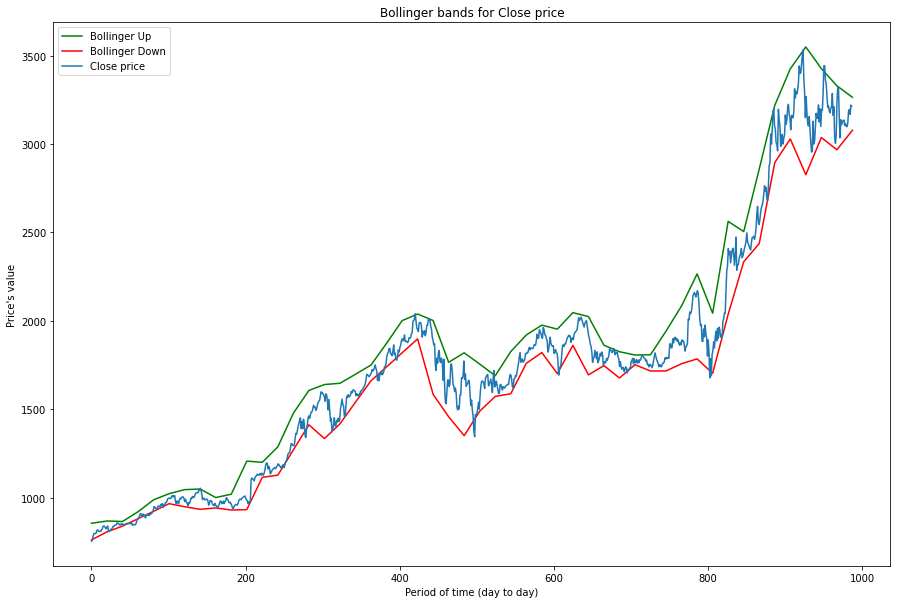

In [51]:
plot_bollinger_bands(df_amazon, 'Close', 20)

### Portfolio Diversification
Ce concept consiste à avoir un nombre diversifié de stocks dans un seul portfolio qui sont correlés. Cela permet de réduire les risques et aussi d'accroitre des revenus. Pour se faire, on calcule les **returns** pour chaque stocks et on les compare au sein d'une matrice de correlation


In [52]:
def create_df_returns():
    """
        :return : new DataFrame containing the returns for each DataFrame.
    """

    #Calcul returns for each dataframe
    returns = []
    cols = []
    for df in LIST_DF:
        name = df.first()['company_name']
        if name != "ZOOM":
            df_returns = df.withColumn("returns", lit(df['Close'] / df.count()))
            list_ret = df_returns.select("returns").rdd.flatMap(lambda x: x).collect()

            returns.append(list_ret)
            cols.append("ret_"+name)

    #Construct data to fit in a DataFrame
    data = []
    lg = len(returns[0])
    for i in range(lg):
        data.append([item[i] for item in returns])
    
    #Create Dataframe with returns for each stocks and plot its correlation matrix
    df_returns = spark.createDataFrame(data, cols)
    return df_returns

['ret_AMAZON', 'ret_APPLE', 'ret_FACEBOOK', 'ret_GOOGLE', 'ret_MICROSOFT', 'ret_TESLA']


/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


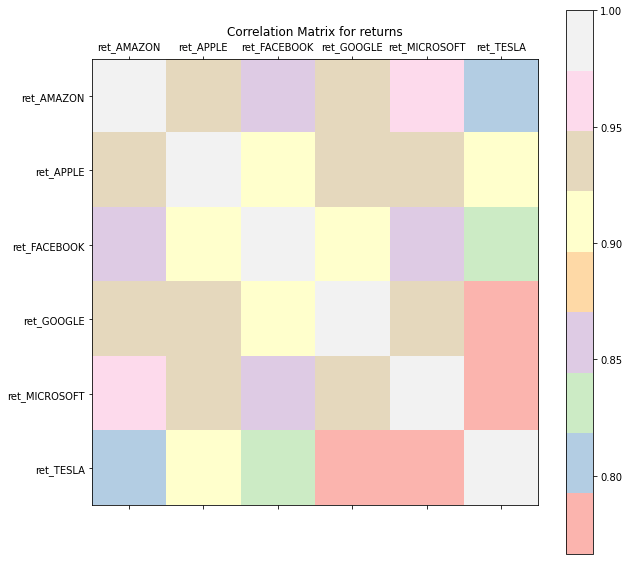

In [53]:
df_returns = create_df_returns()
matrix = get_corr_matrix(df_returns)
visualization_corr_matrix(matrix, df_returns.columns, "returns")

### API
#### Find Company

On crée une fonction qui permet de trouver, avec un nom, les symboles correnspondants à des entreprises qui sont cotées en bourses. Il suffit ensuite de prendre un de ces symboles pour récupérer les informations de ses stocks dans la prochaine fonction.

In [54]:
def find_company(company_name):
    url = 'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords='+ company_name +'&apikey=BG5RZ7YIV7QX2UYN'
    r = requests.get(url)
    data = r.json()
    for e in data['bestMatches']:
        print('Company Name : ' + e['2. name'] + '\n'+ 'Symbol : ' + e['1. symbol'] + '\n---------------------\n')
find_company('Apple')

Company Name : Apple Hospitality REIT Inc
Symbol : APLE
---------------------

Company Name : Apple Inc
Symbol : AAPL
---------------------

Company Name : Apple Inc
Symbol : AAPL34.SAO
---------------------

Company Name : Apple Inc
Symbol : APC.DEX
---------------------

Company Name : Apple Inc
Symbol : APC.FRK
---------------------

Company Name : Apple Green Holding Inc
Symbol : AGPL
---------------------

Company Name : Apple Inc.
Symbol : 0R2V.LON
---------------------

Company Name : Apple Rush Company Inc
Symbol : APRU
---------------------

Company Name : Apple Finance Limited
Symbol : 500014.BSE
---------------------

Company Name : Apple Flavor Fragrance Group Company Ltd
Symbol : 603020.SHH
---------------------



#### Get api stock

On crée une fonction qui permet de trouver, avec le symbole d'une entreprise en bourse, les stocks correnspondants à cette entreprise par mois pendant 20 ans.

In [55]:
def get_api_stock(company_name='AMZN'):
    url_api = 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol='+ company_name + '&apikey=BG5RZ7YIV7QX2UYN'
    request_api = requests.get(url_api)
    data_api = request_api.json()

    schema = StructType([
    StructField('Date', TimestampType(), True),
    StructField('High', FloatType(), True),
    StructField('Low', FloatType(), True),
    StructField('Open', FloatType(), True),
    StructField('Close', FloatType(), True),
    StructField('Volume', FloatType(), True),
    StructField('Adj Close', FloatType(), True),
    StructField('company_name', StringType(), True),
    ])


    df_api = spark.sparkContext.emptyRDD()
    df_api = spark.createDataFrame(df_api,schema)
    columns = ['Date','High','Low','Open','Close','Volume','Adj Close','company_name']
    for e in data_api['Monthly Adjusted Time Series']:
        d = data_api['Monthly Adjusted Time Series']
        newrow_api = spark.createDataFrame([(e,d[e]['2. high'],d[e]['3. low'],d[e]['1. open'],d[e]['4. close'],d[e]['6. volume'],d[e]['5. adjusted close'],company_name)], columns)
        df_api = df_api.union(newrow_api)
    return df_api

get_api_stock('APLE').show(truncate=False)

+----------+-------+-------+-------+-------+--------+---------+------------+
|Date      |High   |Low    |Open   |Close  |Volume  |Adj Close|company_name|
+----------+-------+-------+-------+-------+--------+---------+------------+
|2022-05-20|17.8300|15.2300|17.7000|15.5200|34790676|15.5200  |APLE        |
|2022-04-29|18.6900|16.2300|18.1300|17.6900|44791739|17.6396  |APLE        |
|2022-03-31|18.6500|16.6700|17.7400|17.9700|53778038|17.8694  |APLE        |
|2022-02-28|17.9150|15.8100|16.1600|17.6900|38442512|17.5420  |APLE        |
|2022-01-31|17.0500|14.9550|16.2100|16.1300|32915754|15.9951  |APLE        |
|2021-12-31|16.4100|14.5550|15.3000|16.1500|46934884|16.0149  |APLE        |
|2021-11-30|17.4400|14.3600|15.7200|15.0200|50394080|14.8851  |APLE        |
|2021-10-29|16.4550|15.2934|15.9000|15.7100|30080164|15.5689  |APLE        |
|2021-09-30|16.5900|14.4800|15.1000|15.7300|42681030|15.5888  |APLE        |
|2021-08-31|15.4200|14.1100|15.0300|14.7800|33272540|14.6382  |APLE        |

## Main
Dernière patie, nous crééons une fonction **main** servant à appeler toutes les foncions utiles à l'analyse d'un DataFrame contenant des informations sur les acions d'une certaine entreprise.

Cette fonction **main** appelle cherche tous les fichiers correpondant à des fichiers **CSV** et les traite un par un

In [88]:
def main_visualization():
    all_df = []
    files = os.listdir('./stocks_data')
    for file in files :
        print("Visualization and plots for", file[:-4])
        df_main = read_infos("./stocks_data/" + file) #Infos
        all_df.append(df_main)
        
        #Visualization
        matrix = get_corr_matrix(df_main)
        df_num = df_main.drop("Date", "company_name")
        visualization_corr_matrix(matrix, df_num.columns, name)
        average_price(df_main, y=True)
        plot_avg_price(df_main, y=True)
        plot_evolution_stock_prices(df_main,m=True)
        
        #Insights
        visualization_MACD(df_main, "Close")
        plot_aroon_oscillator(df_main, 10)
        plot_bollinger_bands(df_main, 'Close', 20)
        
        print("================")
        
    print("Moving Average for all prices")
    cols = ["High", "Low", "Open", "Close", "Volume", "Adj Close"]
    for c in cols:
        visualization_moving_average(c, 50)

    print("We want to see all correlations between the differents DataFrame created")
    for (df1,df2) in itertools.combinations(all_df, 2):
        df_merged = merge(df1,df2)
        mat = get_corr_matrix(df_merged)
        final_name = df1.first()['company_name'] + " and " + df2.first()['company_name']
        visualization_corr_matrix(mat,df_merged.columns, final_name)

    #Insight for all DataFrames (correlation matrix for returns)
    df_returns = create_df_returns()
    matrix = get_corr_matrix(df_returns)
    visualization_corr_matrix(matrix, df_returns.columns, "returns")

Visualization and plots for APPLE
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+-------+-------+-------+----------+---------+------------+
|               Date|   High|    Low|   Open|  Close|    Volume|Adj Close|company_name|
+-------------------+-------+-------+-------+-------+----------+---------+------------+
|2017-01-03 00:00:00|29.0825|  28.69|  28.95|29.0375|1.151276E8| 27.27764|       APPLE|
|2017-01-04 00:00:00|29.1275|28.9375|28.9625| 29.005| 8.44724E7|27.247108|       APPLE|
|2017-01-05 00:00:00| 29.215|28.9525|  28.98|29.1525| 8.87744E7|27.385668|       APPLE|
|2017-01-06 00:00:00|  29.54|29.1175| 29.195|29.4775|1.270076E8|27.690971|       APPLE|
|2017-01-09 00:00:00|29.8575| 29.485|29.4875

/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


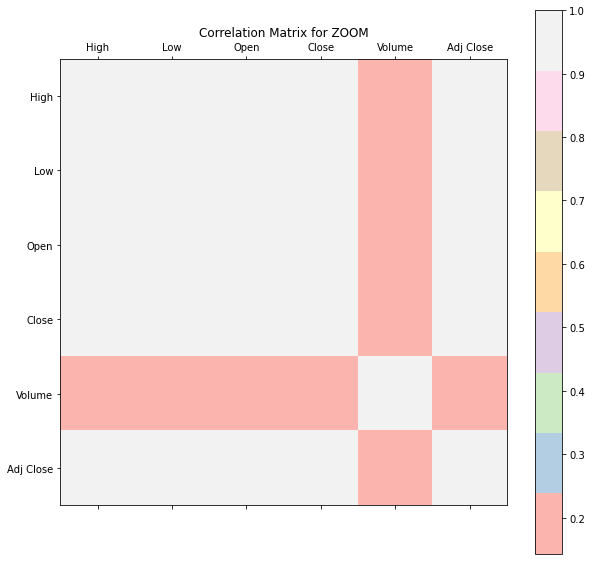

Average open price and close price in 2017
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|37.61122511297583|37.637768870805836|
+-----------------+------------------+

Average open price and close price in 2018
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|47.277858642942874|47.263356698936676|
+------------------+------------------+

Average open price and close price in 2019
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|51.96727168370807|52.063988049825035|
+-----------------+------------------+

Average open price and close price in 2020
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|92.48257523237892|92.56351605198414|
+-----------------+-----------------+



Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


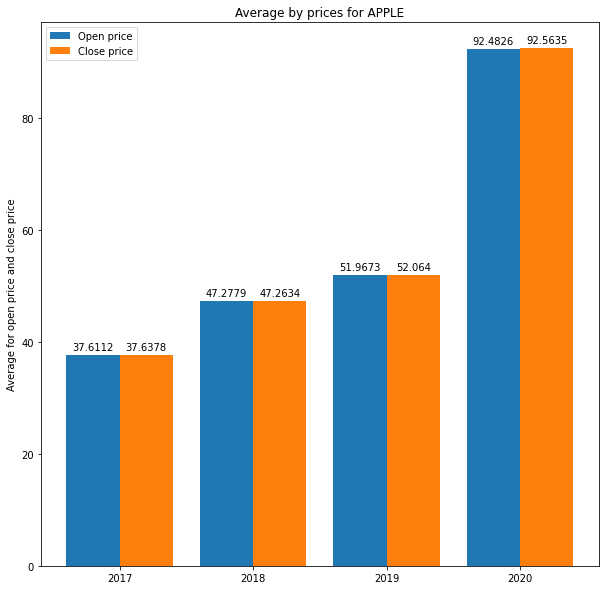

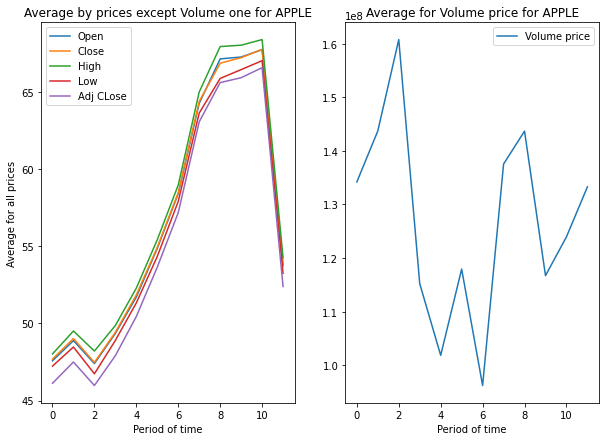

Visualization and plots for ZOOM
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+------+------+------+---------+---------+------------+
|               Date|   High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+-------+------+------+------+---------+---------+------------+
|2019-04-18 00:00:00|   66.0|60.321|  65.0|  62.0|2.57647E7|     62.0|        ZOOM|
|2019-04-22 00:00:00|   68.9| 59.94|  61.0|  65.7|9949700.0|     65.7|        ZOOM|
|2019-04-23 00:00:00| 74.169| 65.55| 66.87|  69.0|6786500.0|     69.0|        ZOOM|
|2019-04-24 00:00:00|   71.5| 63.16|  71.4|  63.2|4973500.0|     63.2|        ZOOM|
|2019-04-25 00:00:00|  66.85|  62.6| 64.74|  65.0|3863300.0|     65.0|   

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


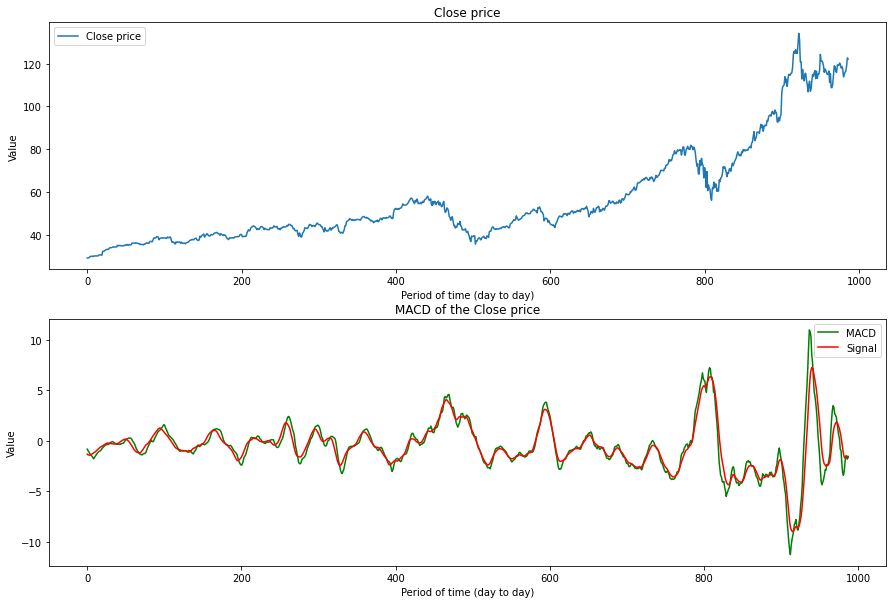

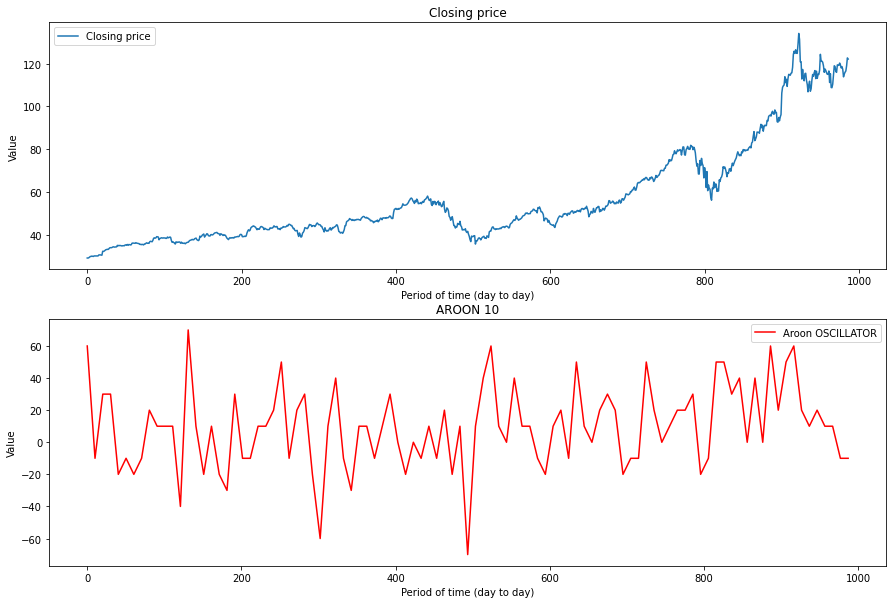

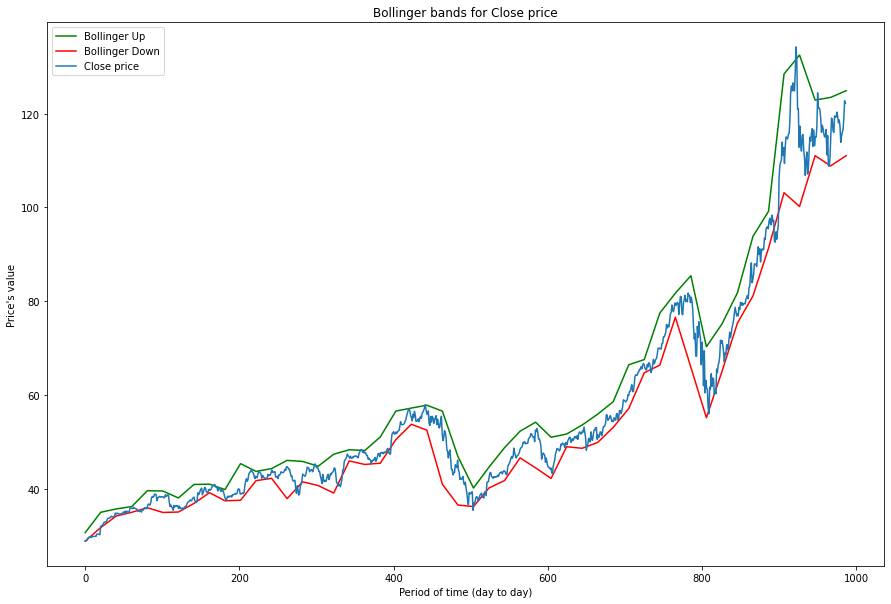

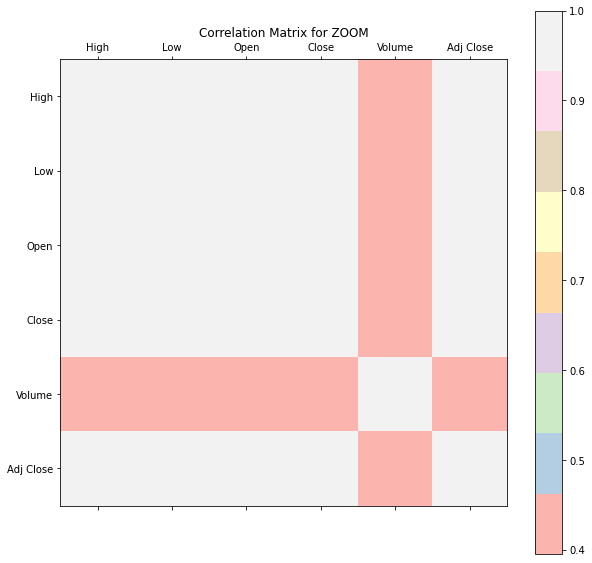

Average open price and close price in 2019
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|80.39499985769893|80.23938206876262|
+-----------------+-----------------+

Average open price and close price in 2020
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|251.14446795549514|251.74615088859852|
+------------------+------------------+



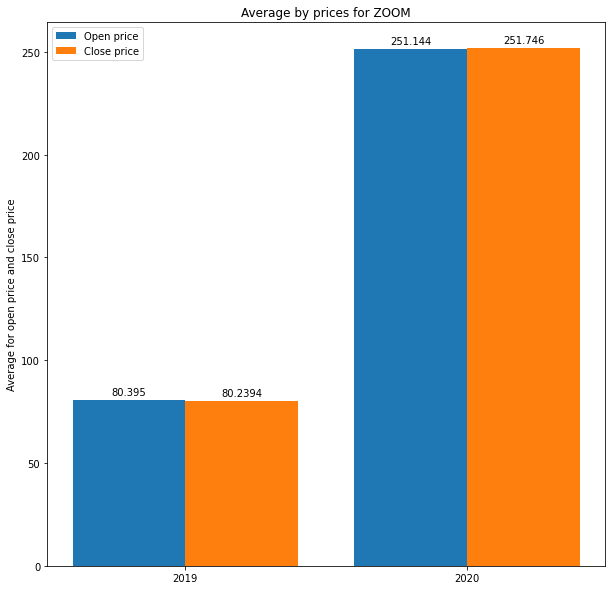

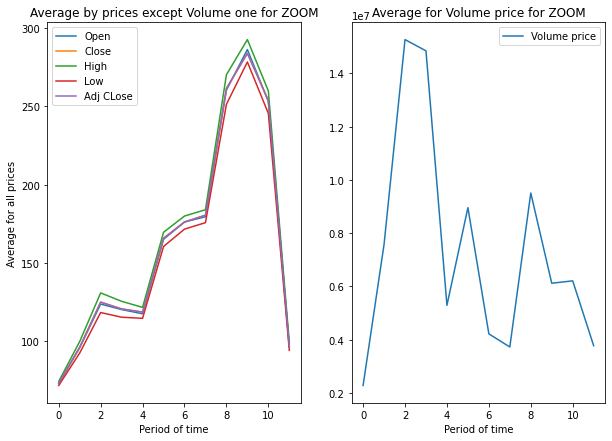

Visualization and plots for MICROSOFT
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-----+-----+-----+-----+---------+---------+------------+
|               Date| High|  Low| Open|Close|   Volume|Adj Close|company_name|
+-------------------+-----+-----+-----+-----+---------+---------+------------+
|2017-01-03 00:00:00|62.84|62.13|62.79|62.58|2.06941E7|58.673244|   MICROSOFT|
|2017-01-04 00:00:00|62.75|62.12|62.48| 62.3|  2.134E7|58.410725|   MICROSOFT|
|2017-01-05 00:00:00|62.66|62.03|62.19| 62.3| 2.4876E7|58.410725|   MICROSOFT|
|2017-01-06 00:00:00|63.15|62.04| 62.3|62.84|1.99229E7|58.917015|   MICROSOFT|
|2017-01-09 00:00:00|63.08|62.54|62.76|62.64|2.03827E7|58.729496|   MICROSOFT|
|2017-01-10 00:00:00|63.

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


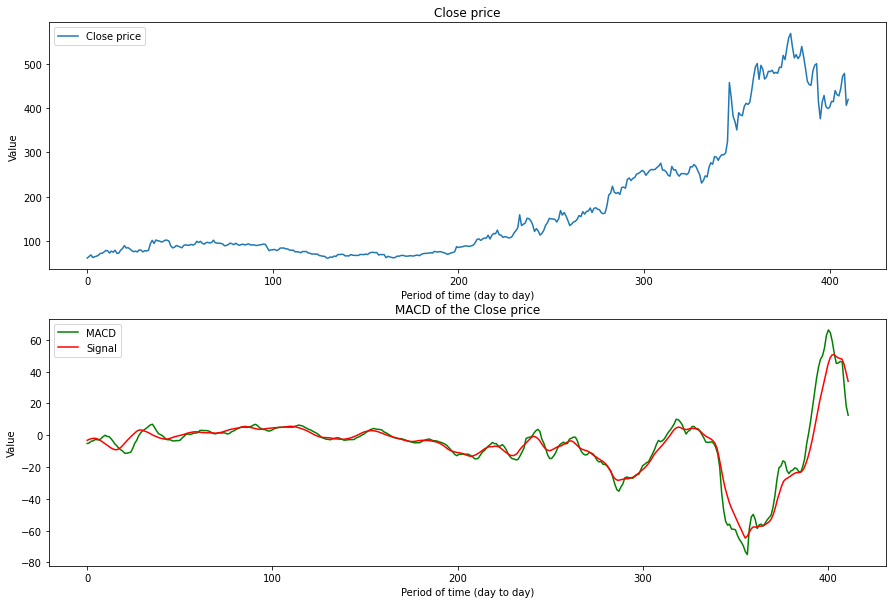

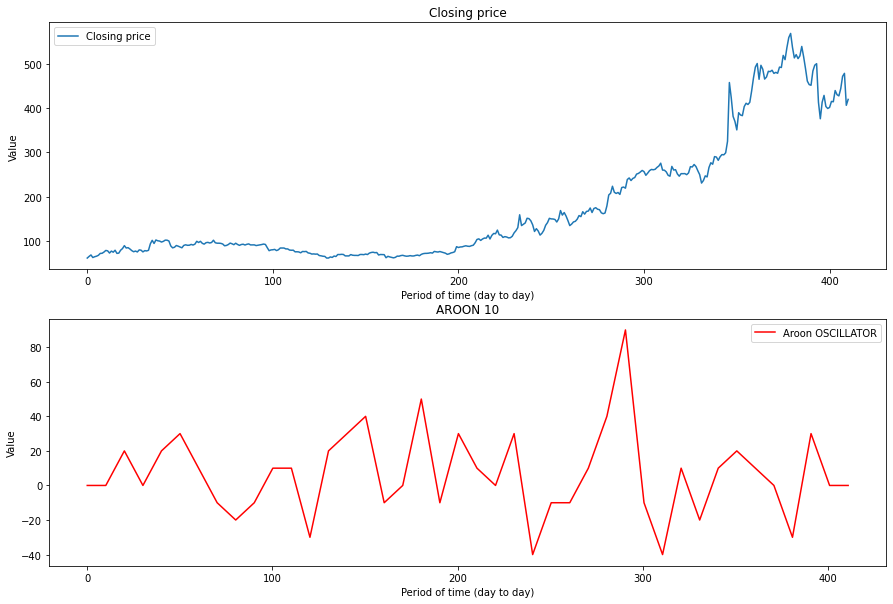

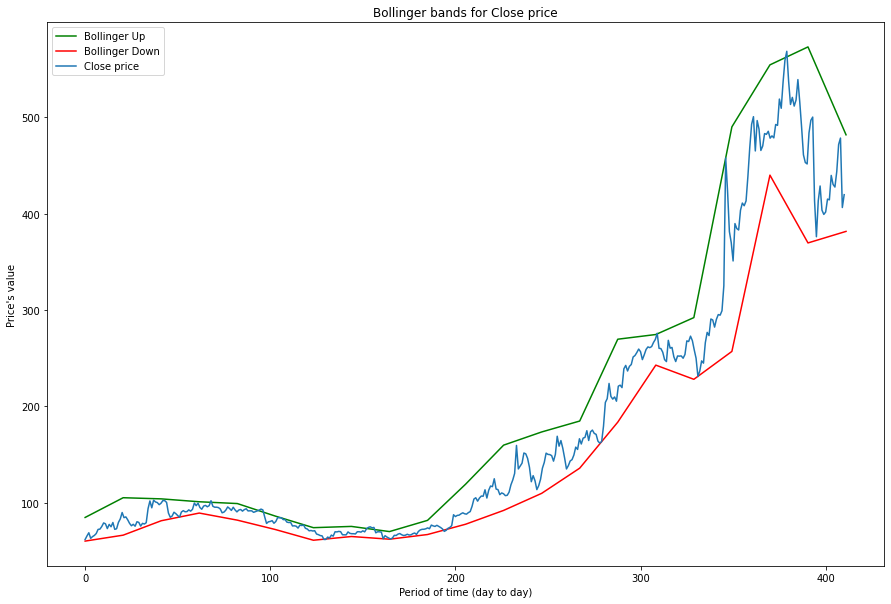

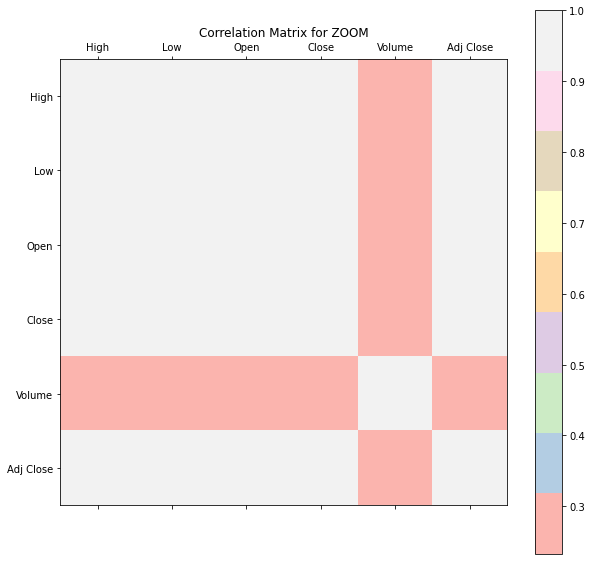

Average open price and close price in 2017
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|71.95430287516925|71.98402421502954|
+-----------------+-----------------+

Average open price and close price in 2018
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|101.12235092831799|101.03398411967365|
+------------------+------------------+

Average open price and close price in 2019
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|130.33904787093874|130.38202400813026|
+------------------+------------------+

Average open price and close price in 2020
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|190.76480678836674|190.8616180419922|
+------------------+-----------------+



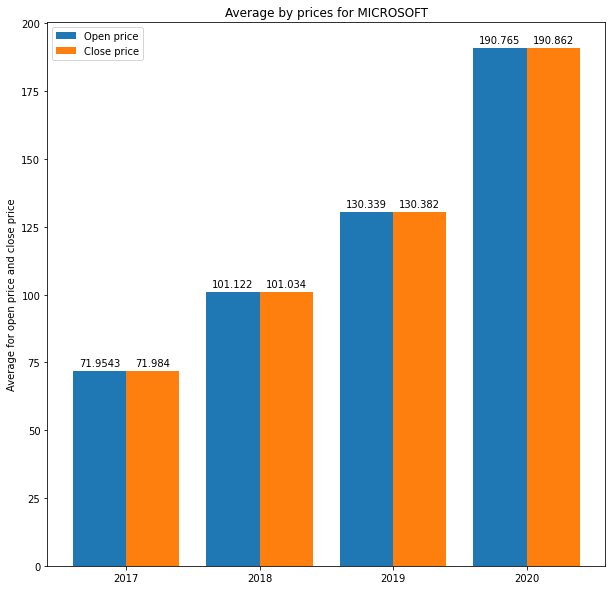

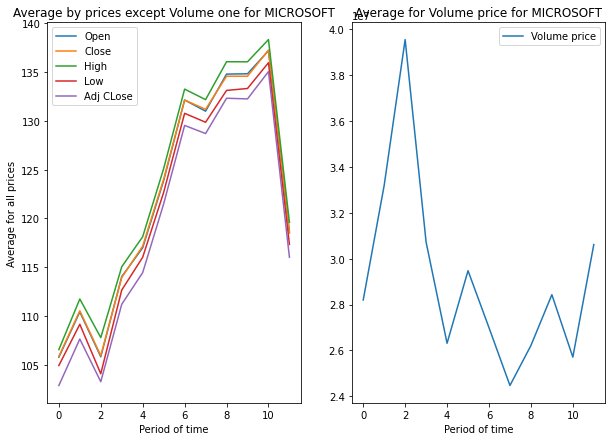

Visualization and plots for FACEBOOK
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|117.84|115.51|116.03|116.86|2.06639E7|   116.86|    FACEBOOK|
|2017-01-04 00:00:00|119.66|117.29|117.55|118.69|1.96309E7|   118.69|    FACEBOOK|
|2017-01-05 00:00:00|120.95|118.32|118.86|120.67|1.94922E7|   120.67|    FACEBOOK|
|2017-01-06 00:00:00|123.88|120.03|120.98|123.41|2.85453E7|   123.41|    FACEBOOK|
|2017-01-09 00:00:00|125.43|123.04|123.55| 124.9|2.28804E7|    124.9|    FAC

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


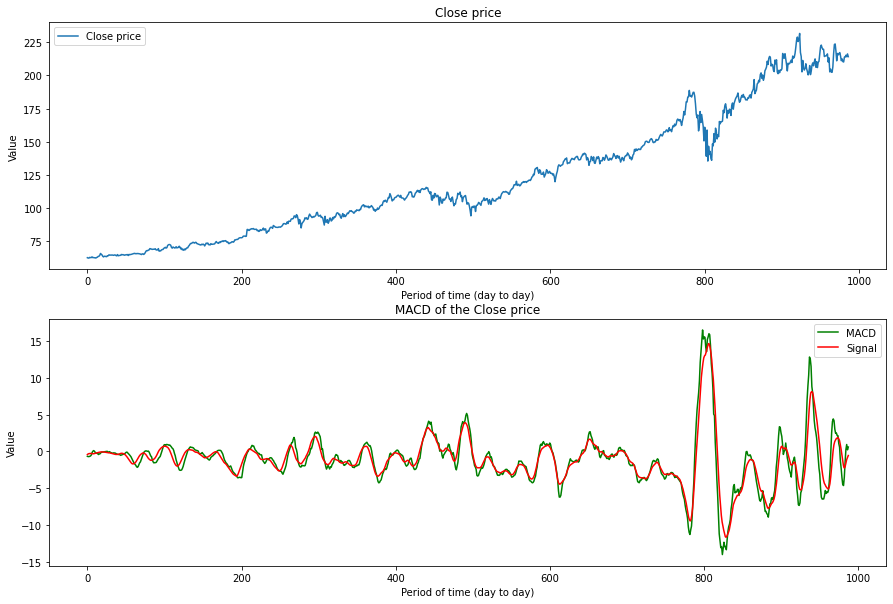

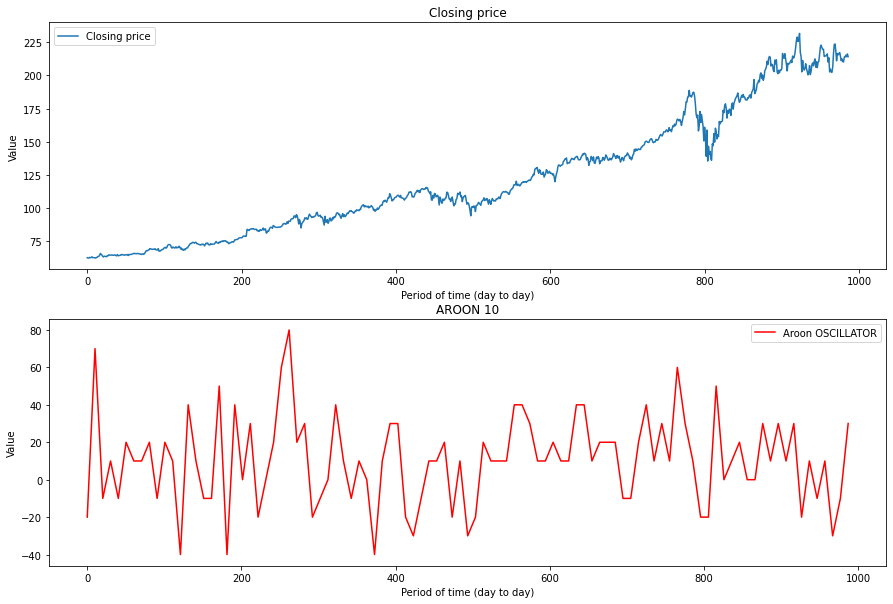

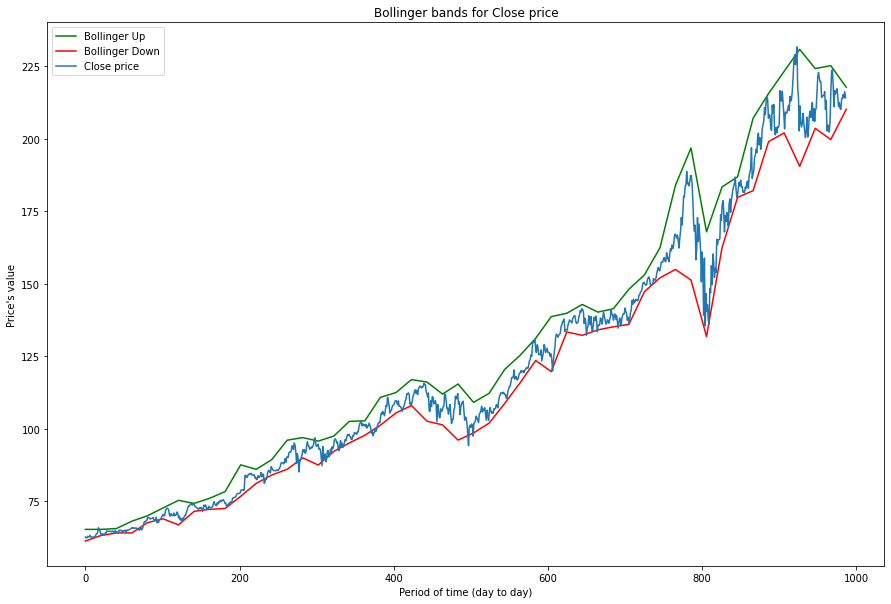

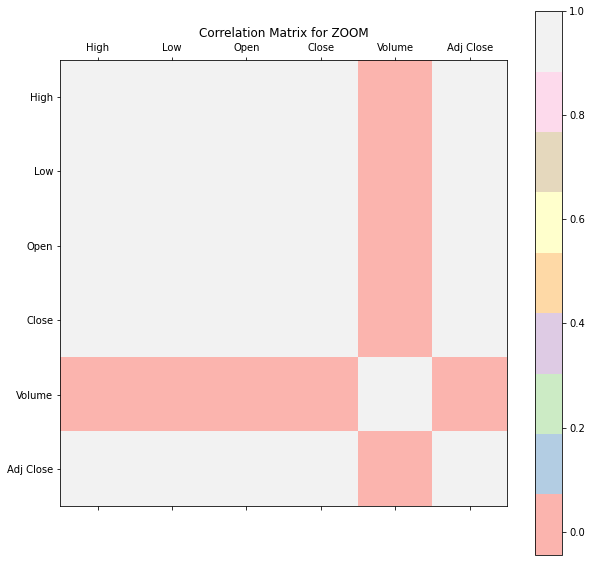

Average open price and close price in 2017
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|156.4810755756272|156.57617537053932|
+-----------------+------------------+

Average open price and close price in 2018
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|171.4729481427318|171.5109556889629|
+-----------------+-----------------+

Average open price and close price in 2019
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|181.56654727269733|181.6374996124752|
+------------------+-----------------+

Average open price and close price in 2020
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|230.78562233069425|231.0295712057613|
+------------------+-----------------+



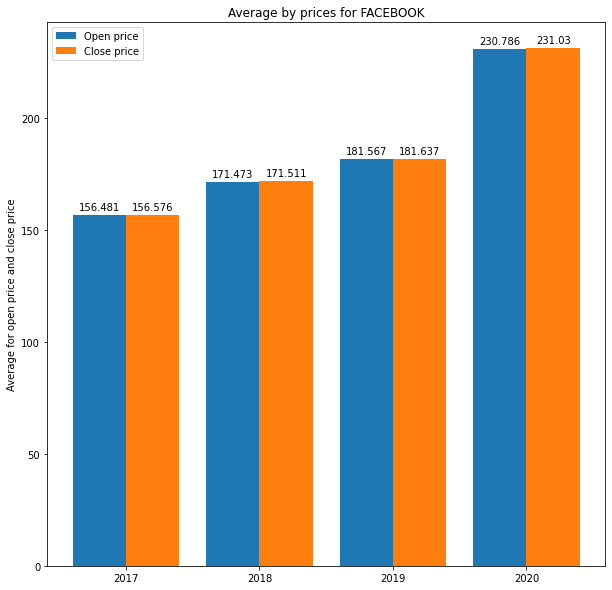

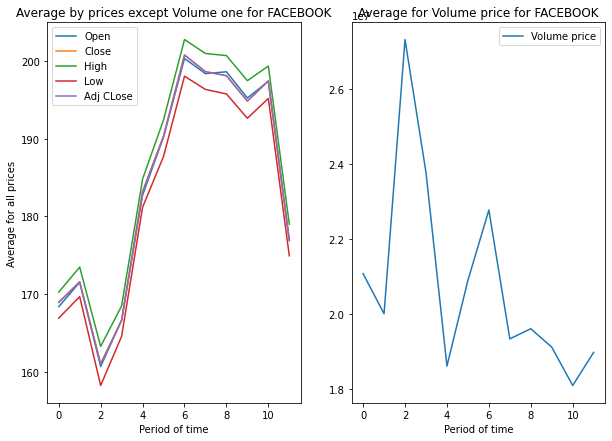

Visualization and plots for AMAZON
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMA

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


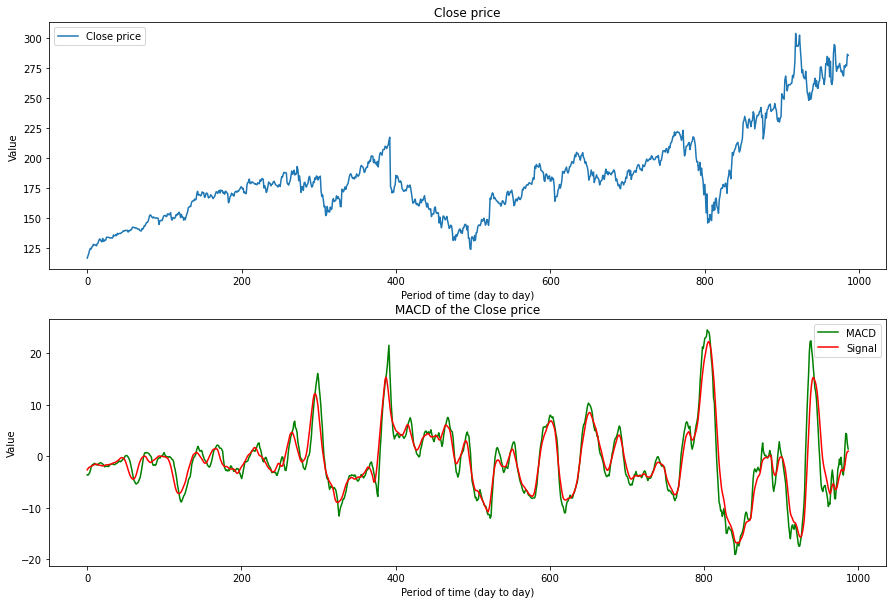

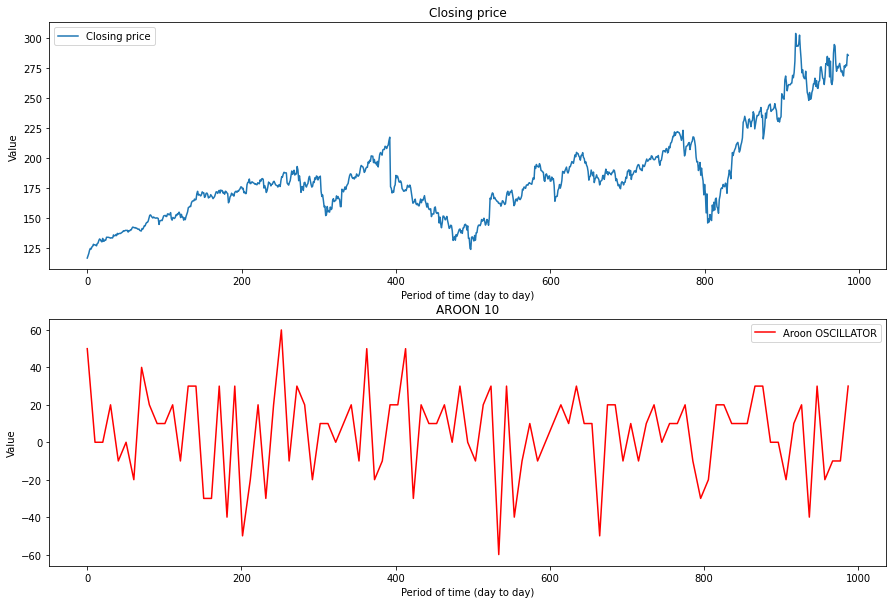

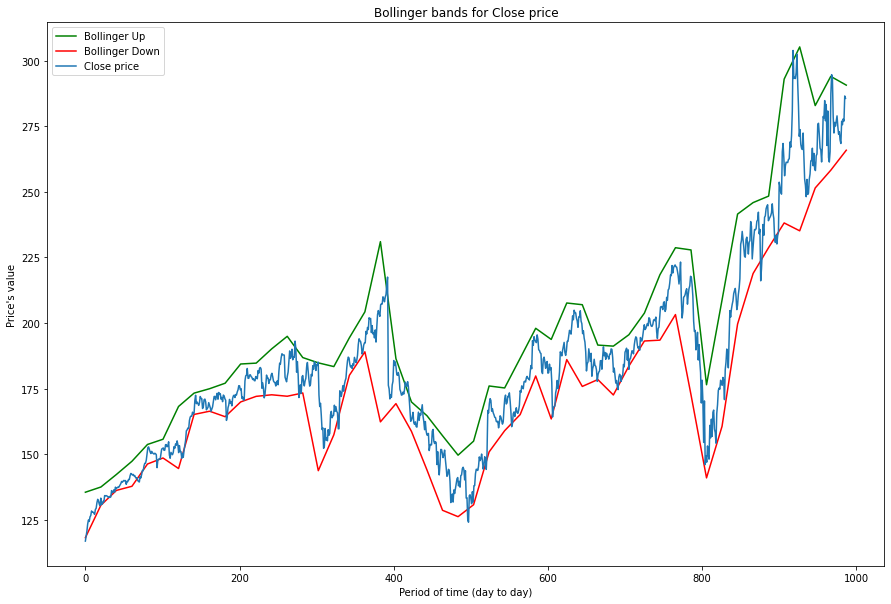

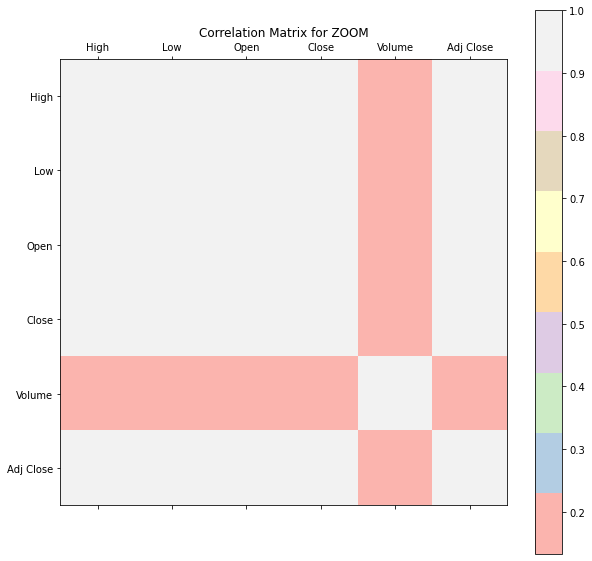

Average open price and close price in 2017
+----------------+-----------------+
|       avg(Open)|       avg(Close)|
+----------------+-----------------+
|968.275618959708|968.1670116409363|
+----------------+-----------------+

Average open price and close price in 2018
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|1644.0727091633466|1641.7261758629545|
+------------------+------------------+

Average open price and close price in 2019
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|1788.7461896623884|1789.189206077939|
+------------------+-----------------+

Average open price and close price in 2020
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|2636.5054538710433|2636.649604240712|
+------------------+-----------------+



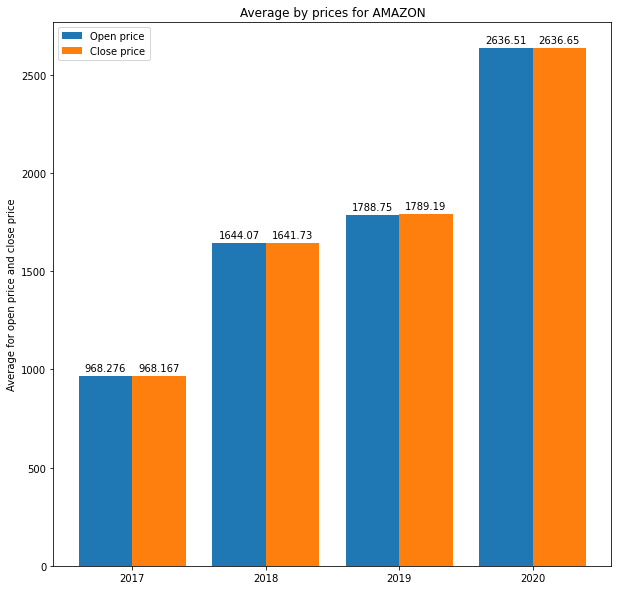

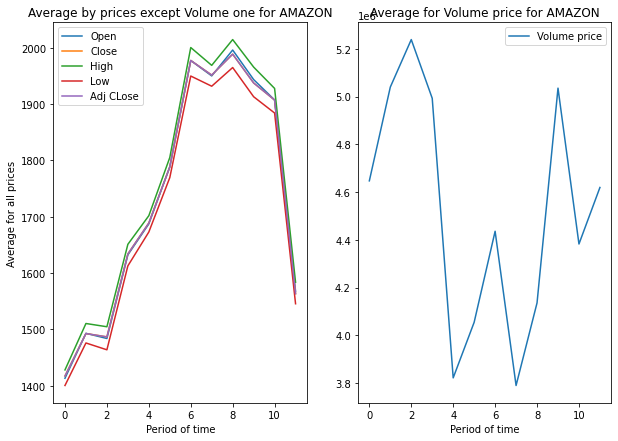

Visualization and plots for GOOGLE
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-------+-------+------+-------+---------+---------+------------+
|               Date|   High|    Low|  Open|  Close|   Volume|Adj Close|company_name|
+-------------------+-------+-------+------+-------+---------+---------+------------+
|2017-01-03 00:00:00| 789.63|  775.8|778.81| 786.14|1657300.0|   786.14|      GOOGLE|
|2017-01-04 00:00:00| 791.34| 783.16|788.36|  786.9|1073000.0|    786.9|      GOOGLE|
|2017-01-05 00:00:00| 794.48| 785.02|786.08| 794.02|1335200.0|   794.02|      GOOGLE|
|2017-01-06 00:00:00|  807.9|792.204|795.26| 806.15|1640200.0|   806.15|      GOOGLE|
|2017-01-09 00:00:00|809.966| 802.83| 806.4| 806.65|12746

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


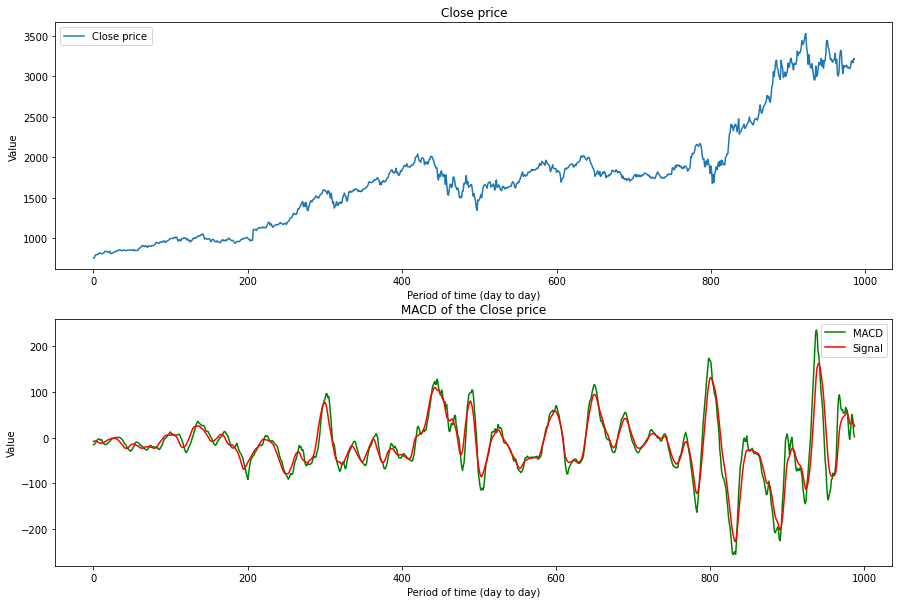

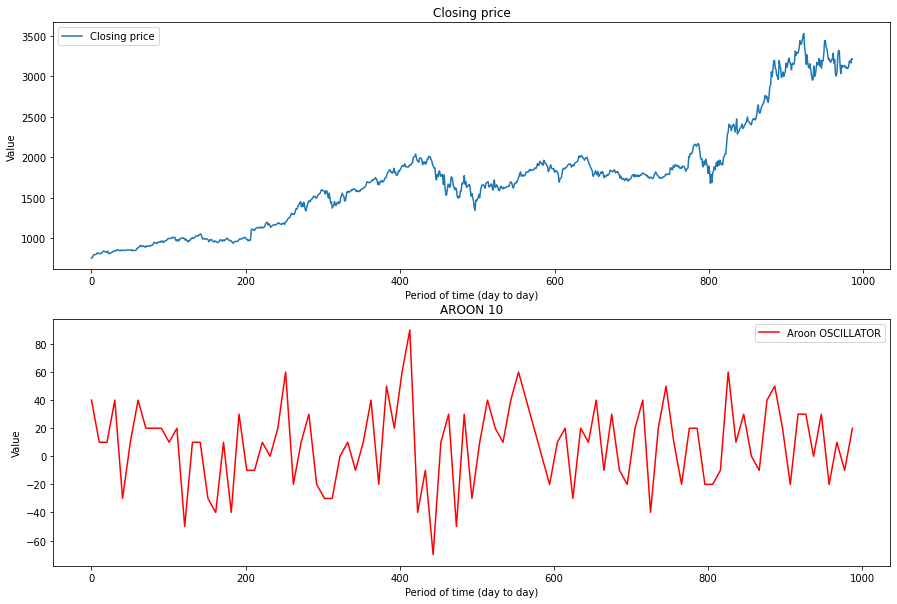

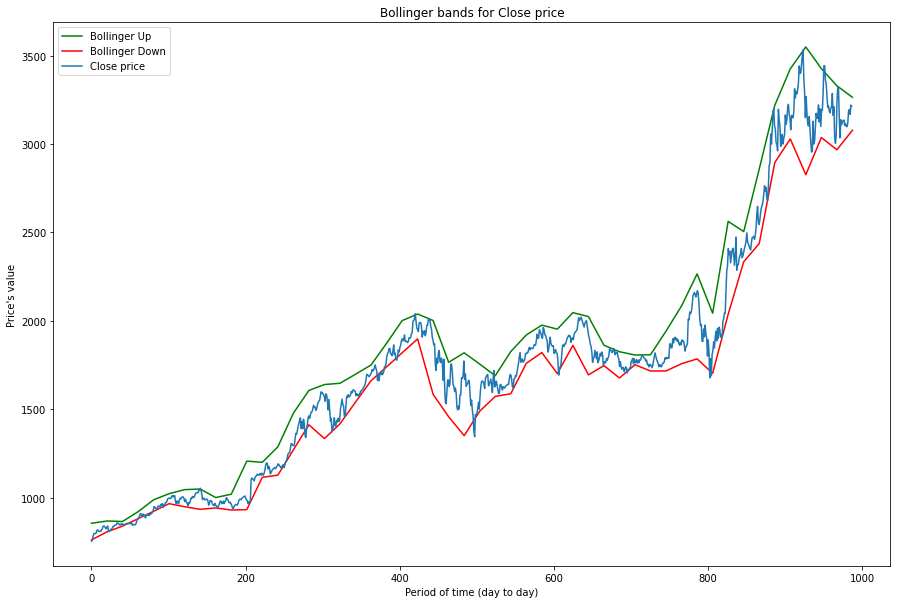

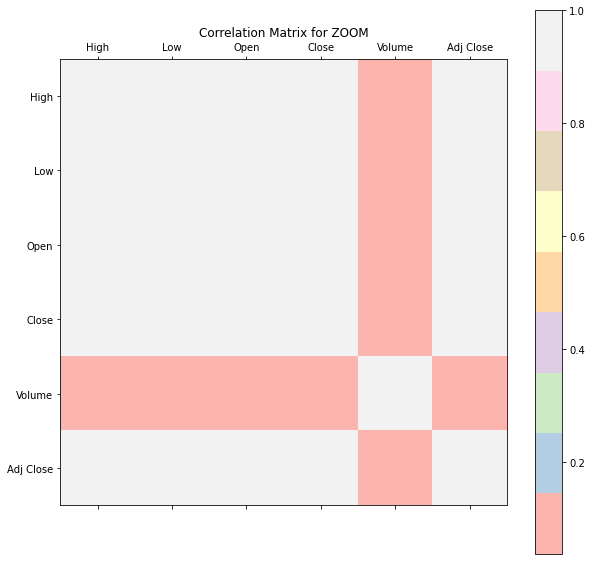

Average open price and close price in 2017
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|921.1211927193569|921.7808373439834|
+-----------------+-----------------+

Average open price and close price in 2018
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|1113.554100735729|1113.225134131443|
+-----------------+-----------------+

Average open price and close price in 2019
+------------------+-----------------+
|         avg(Open)|       avg(Close)|
+------------------+-----------------+
|1187.0098210894873|1188.393057444739|
+------------------+-----------------+

Average open price and close price in 2020
+------------------+------------------+
|         avg(Open)|        avg(Close)|
+------------------+------------------+
|1454.6135625880163|1456.6964127045333|
+------------------+------------------+



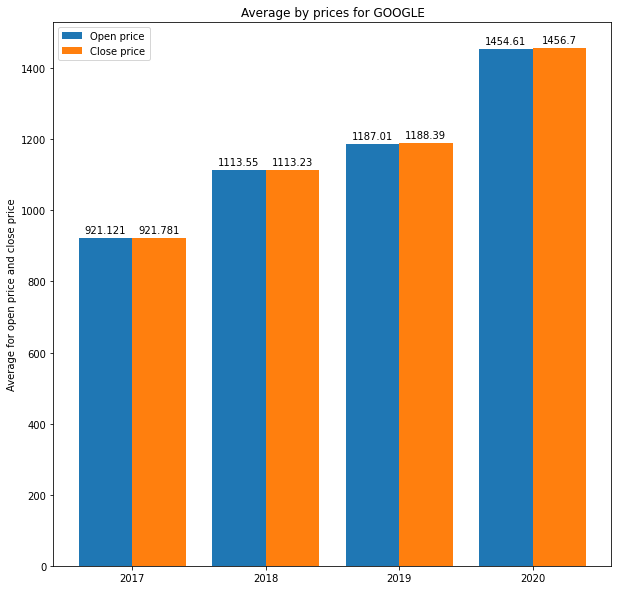

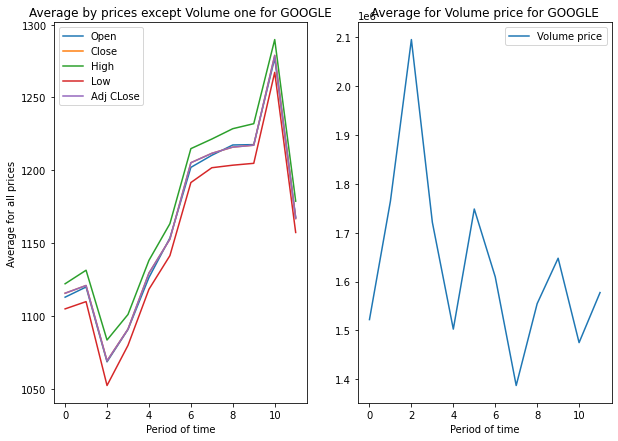

Visualization and plots for TESLA
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+------+------+------+------+---------+---------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|
+-------------------+------+------+------+------+---------+---------+------------+
|2017-01-03 00:00:00|44.066|42.192|42.972|43.398|2.96165E7|   43.398|       TESLA|
|2017-01-04 00:00:00|  45.6|42.862| 42.95|45.398|5.60675E7|   45.398|       TESLA|
|2017-01-05 00:00:00|45.496| 44.39|45.284| 45.35|2.95585E7|    45.35|       TESLA|
|2017-01-06 00:00:00|46.062| 45.09|45.386|45.802|2.76395E7|   45.802|       TESLA|
|2017-01-09 00:00:00|46.384|  45.6|45.794|46.256|1.98975E7|   46.256|       TES

/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


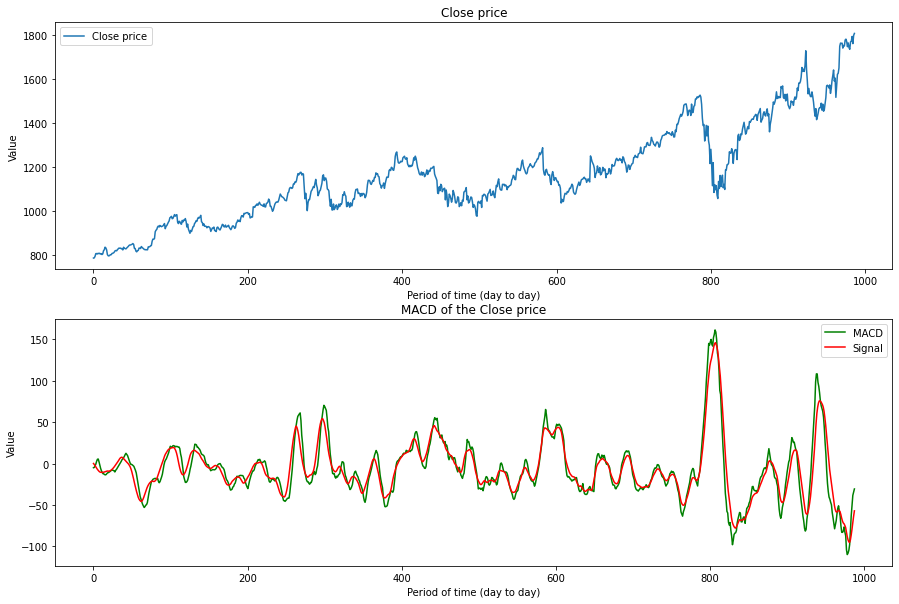

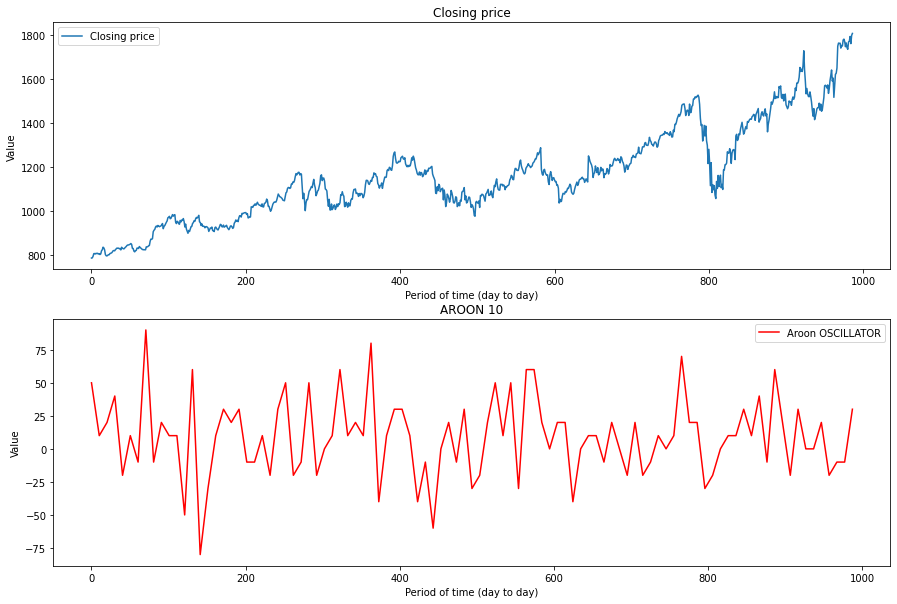

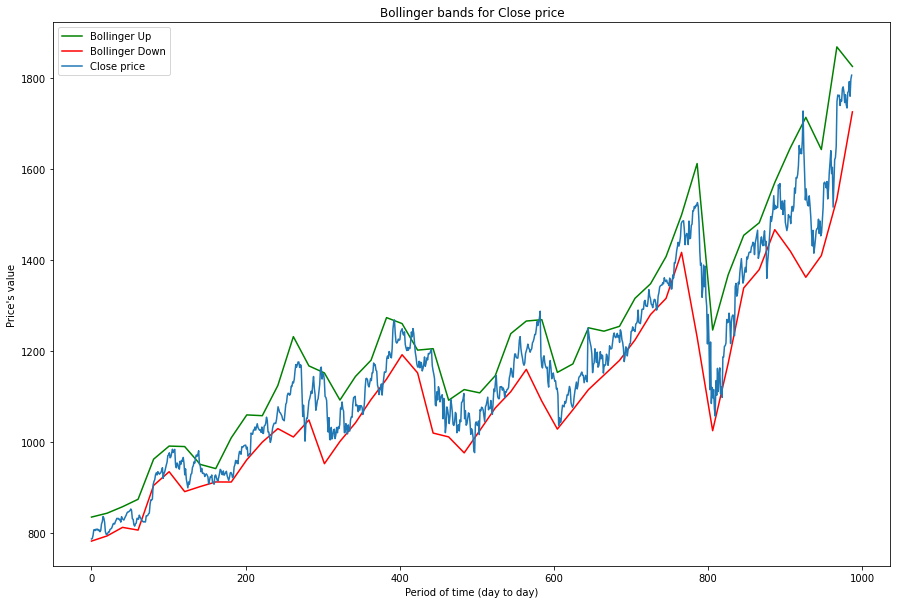

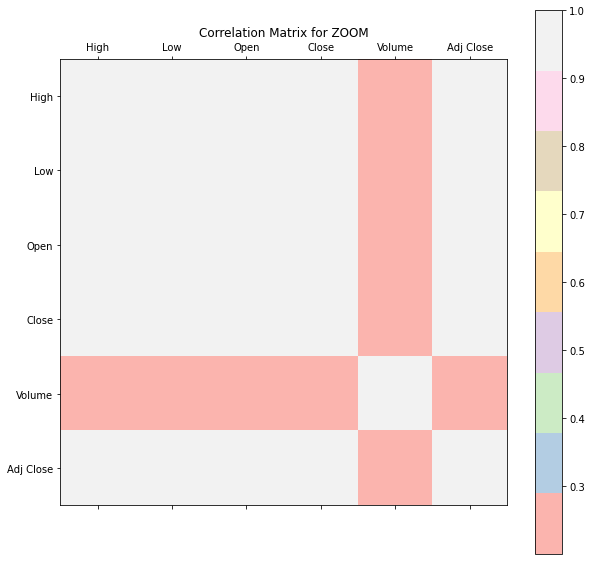

Average open price and close price in 2017
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|62.85924295980142|62.863258969736286|
+-----------------+------------------+

Average open price and close price in 2018
+-----------------+-----------------+
|        avg(Open)|       avg(Close)|
+-----------------+-----------------+
|63.43669347269127|63.46198397328654|
+-----------------+-----------------+

Average open price and close price in 2019
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|54.60562690855965|54.706039686051625|
+-----------------+------------------+

Average open price and close price in 2020
+-----------------+------------------+
|        avg(Open)|        avg(Close)|
+-----------------+------------------+
|259.2505243980833|259.50230853035725|
+-----------------+------------------+



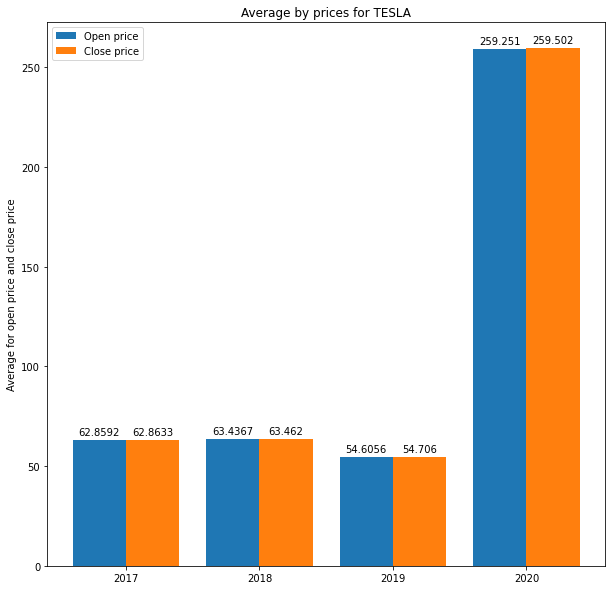

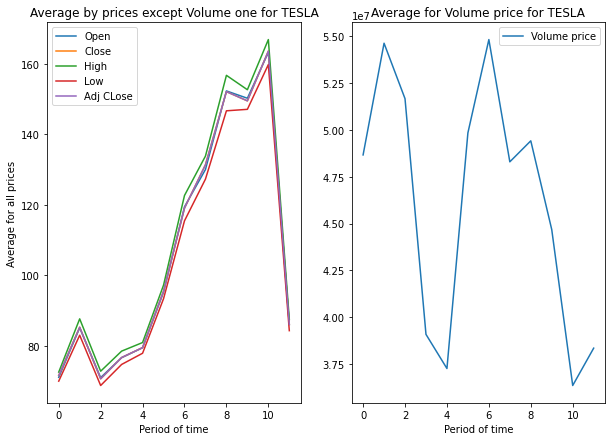

Moving Average for all prices


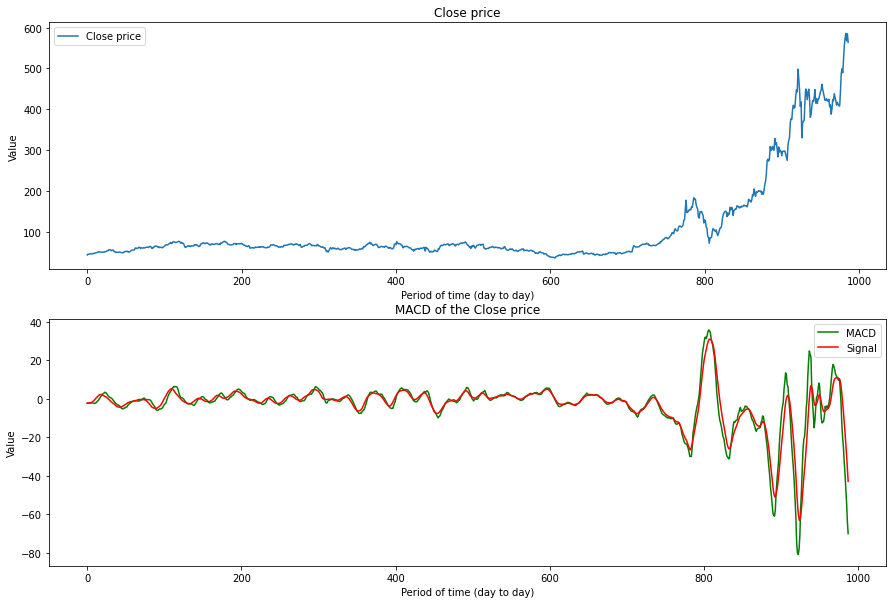

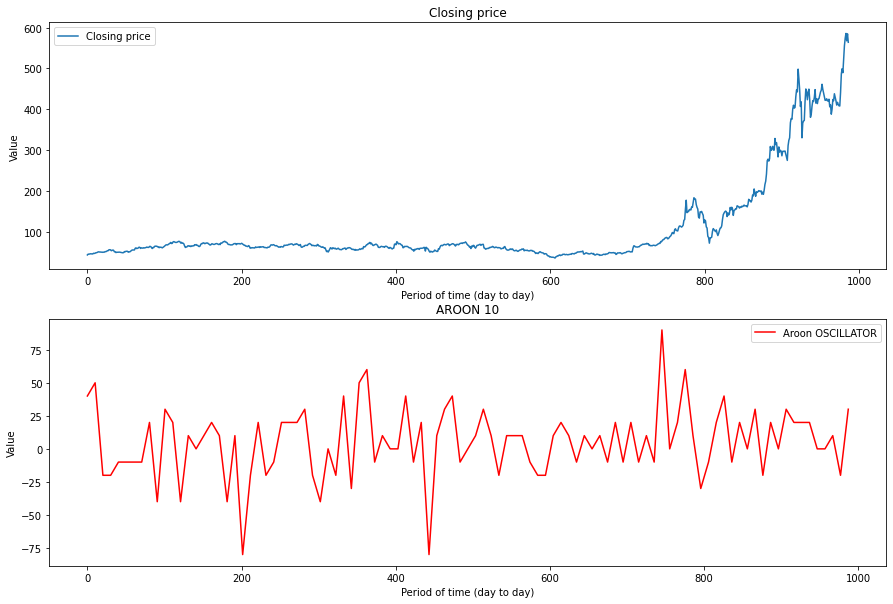

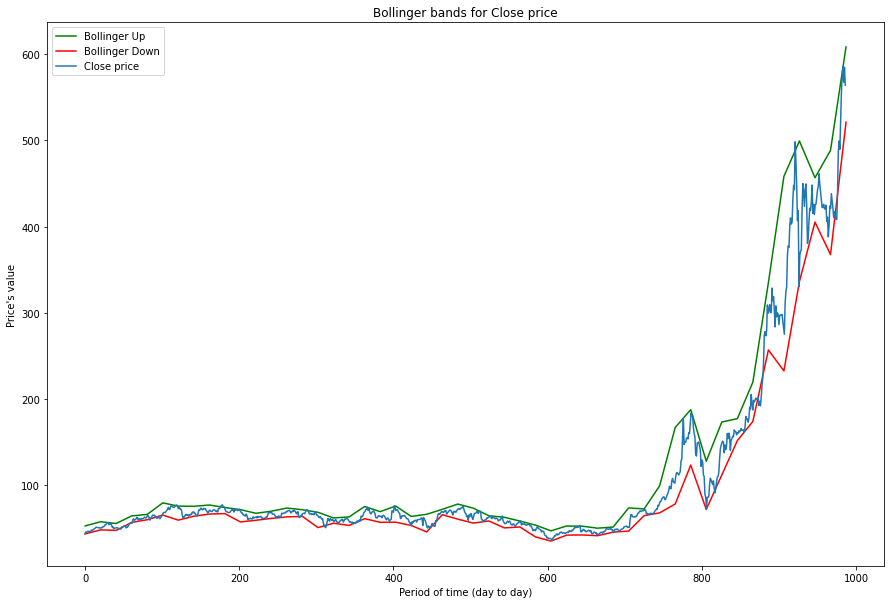

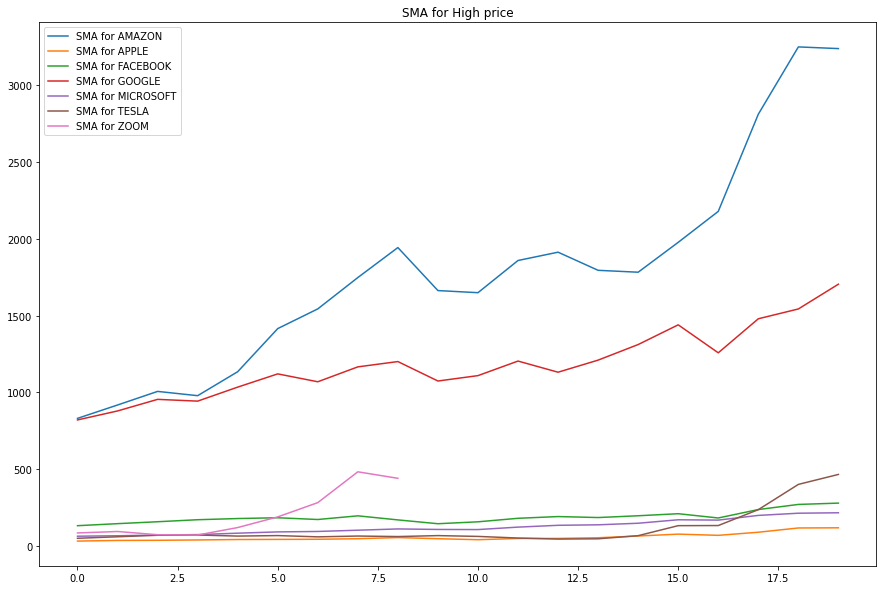

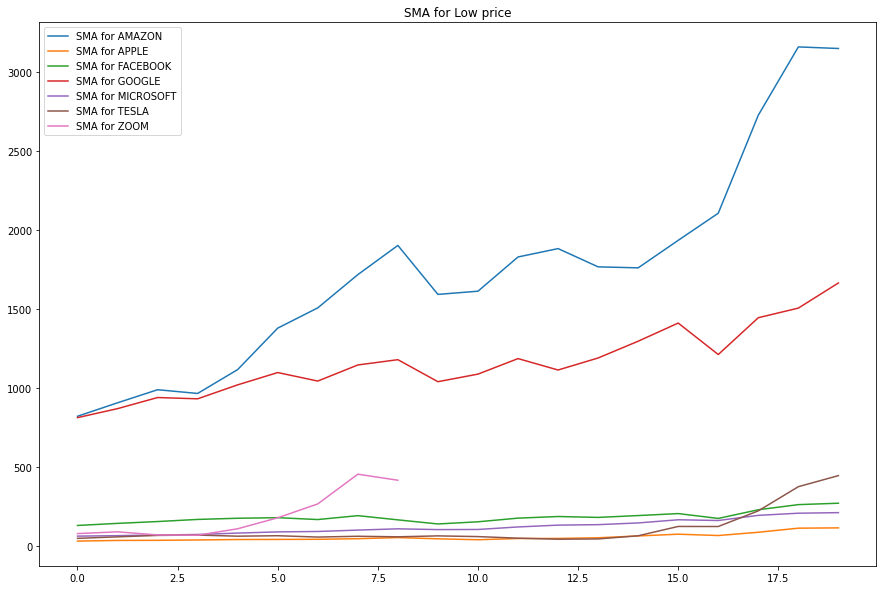

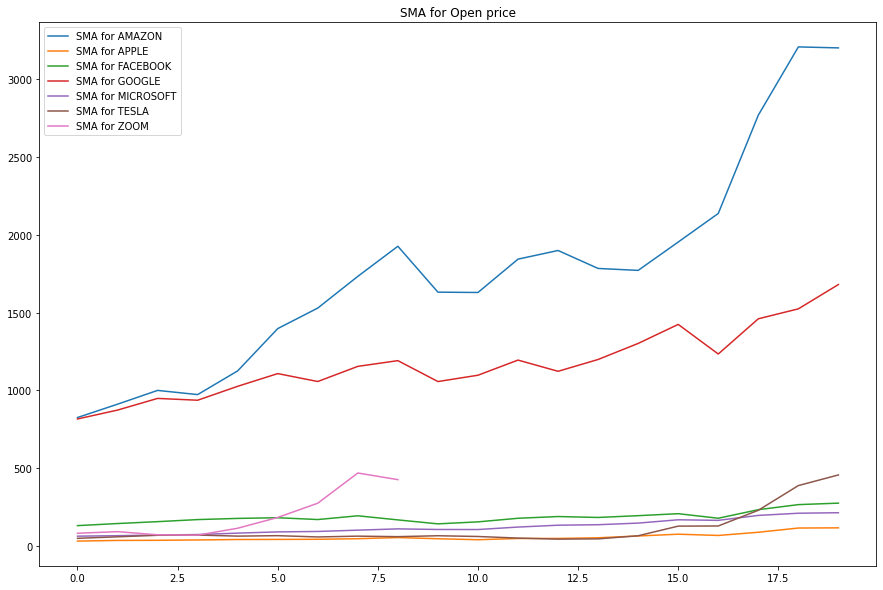

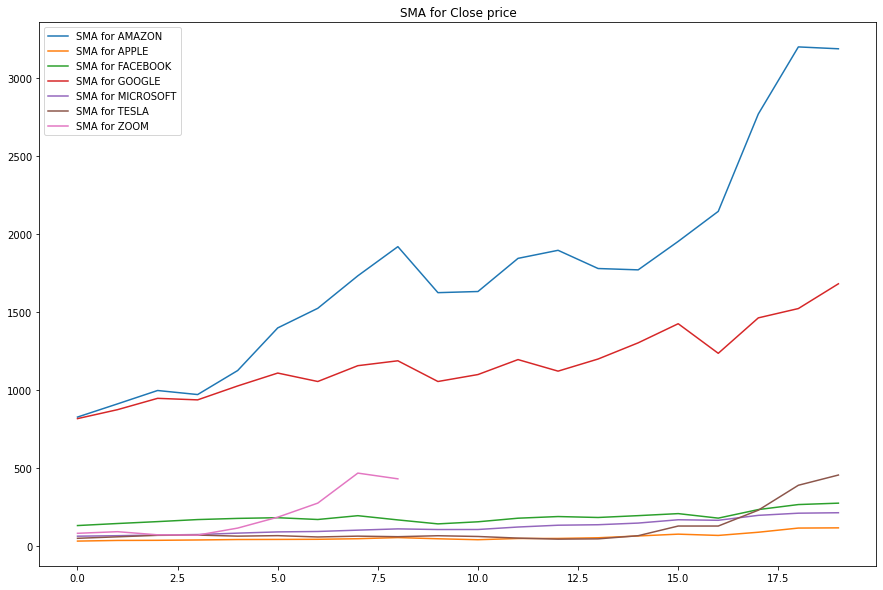

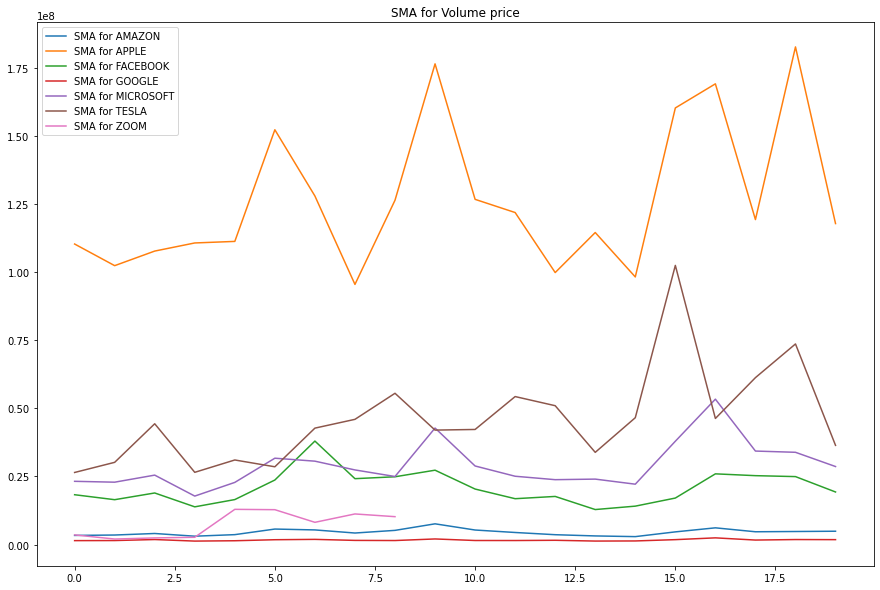

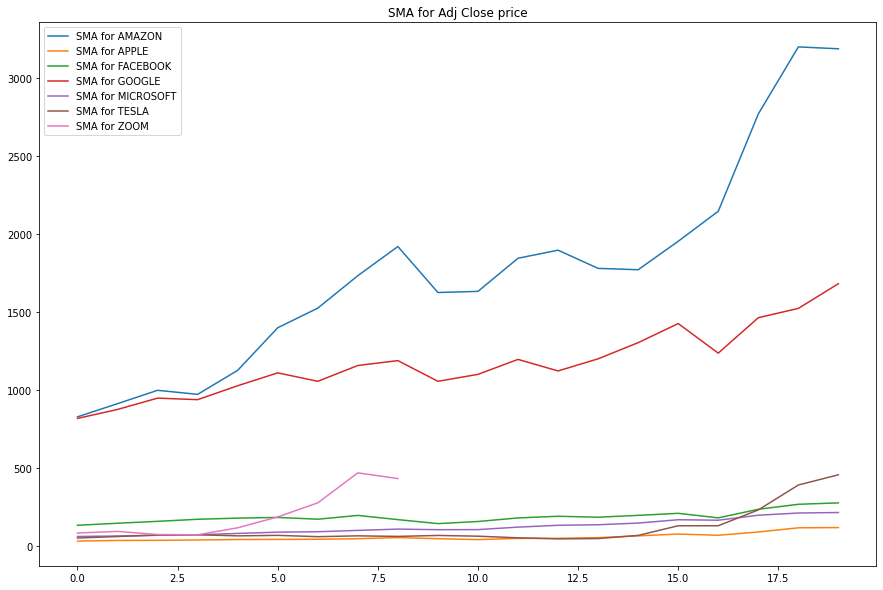

We want to see all correlations between the differents DataFrame created
['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


/home/alex/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_6301/617499620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/tmp/ipykernel_6301/617499620.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


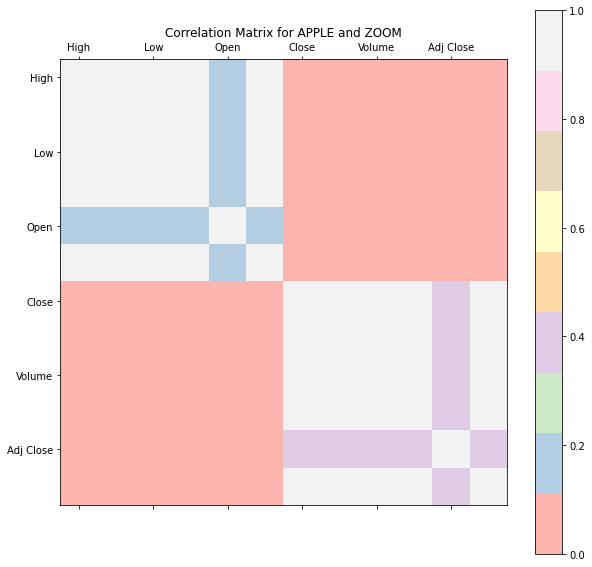

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


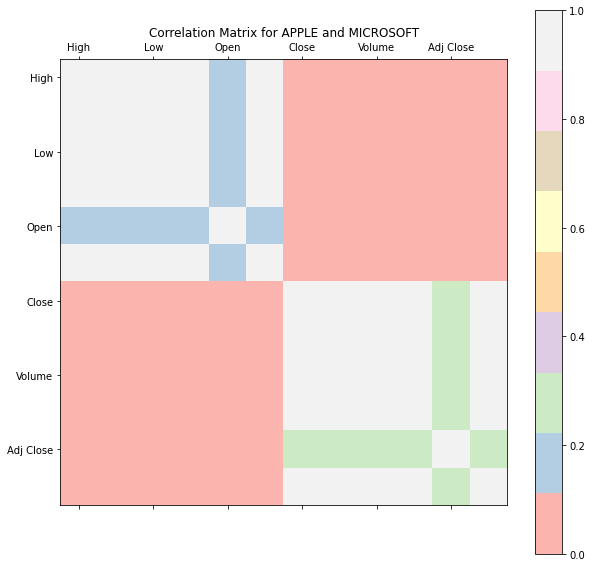

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


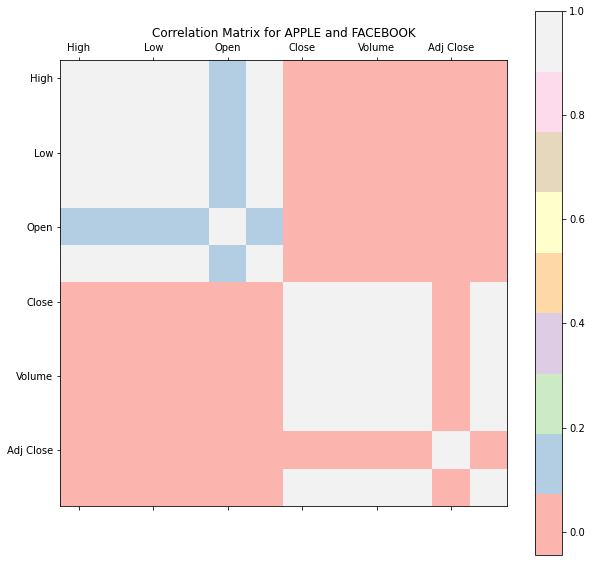

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


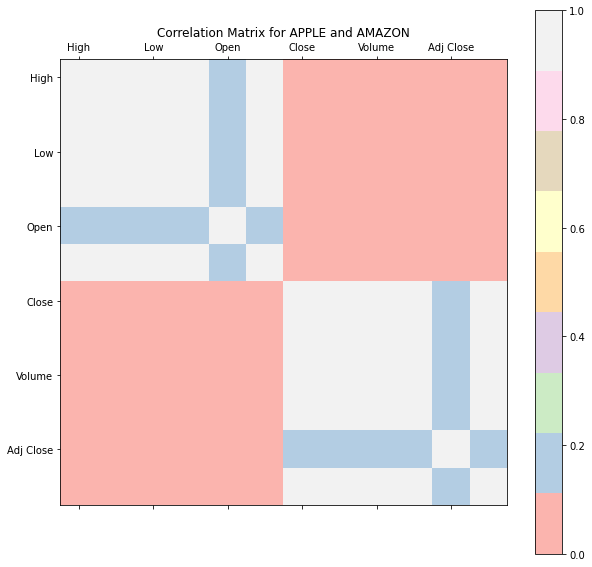

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


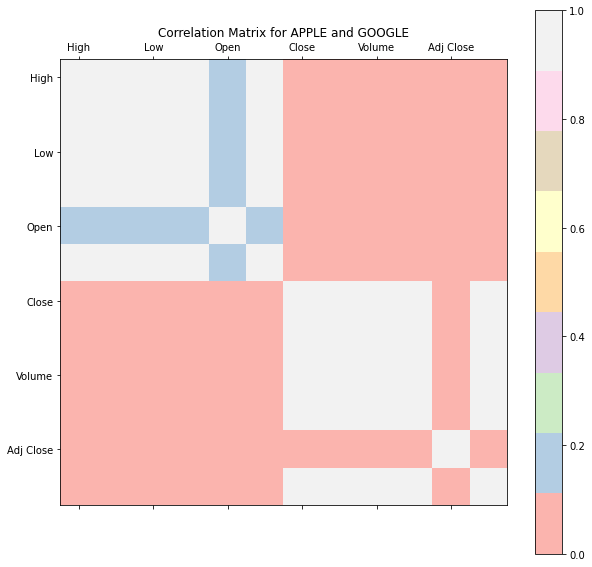

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


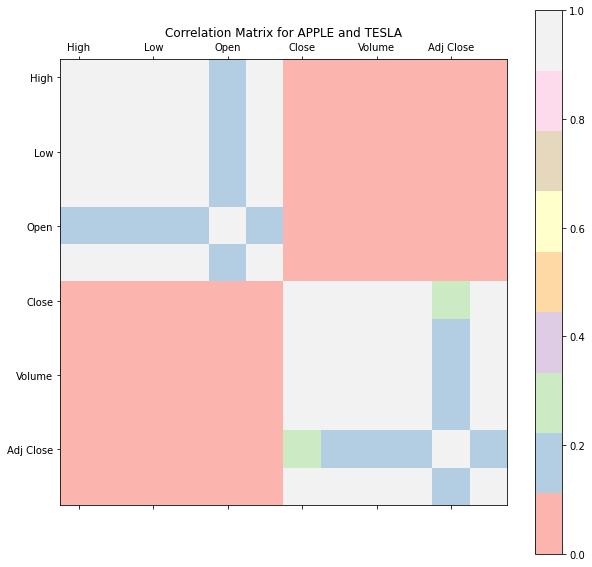

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


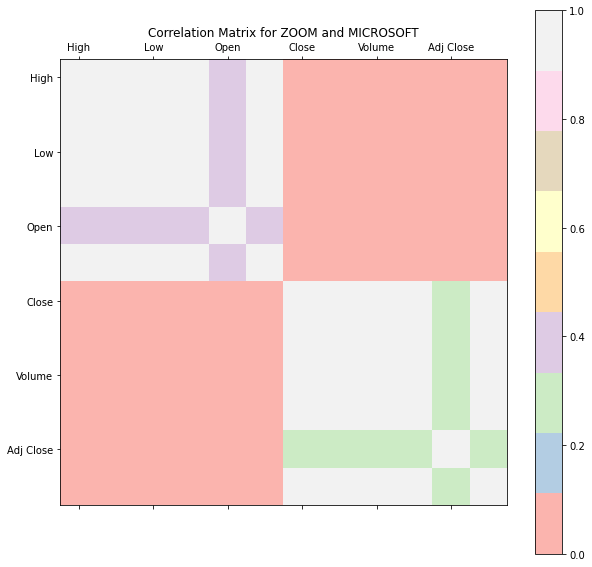

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


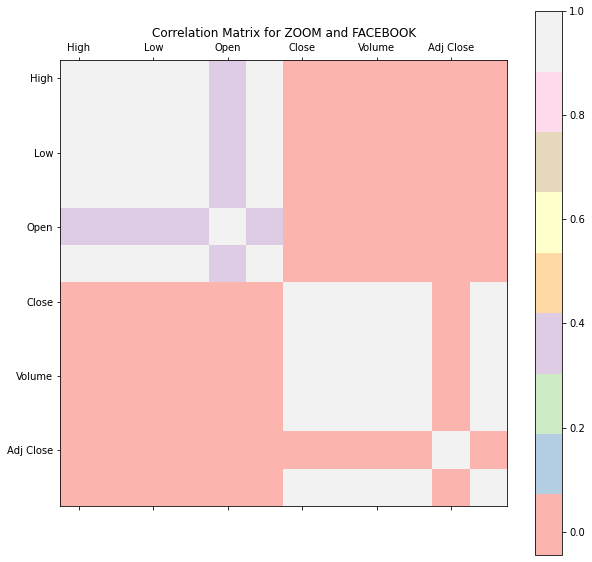

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


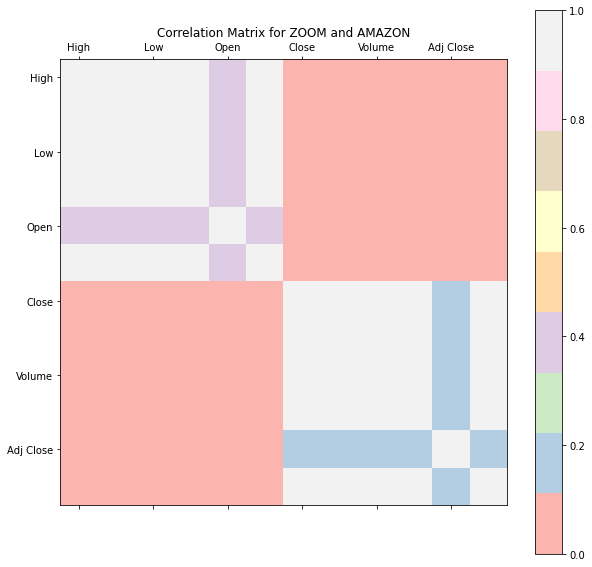

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


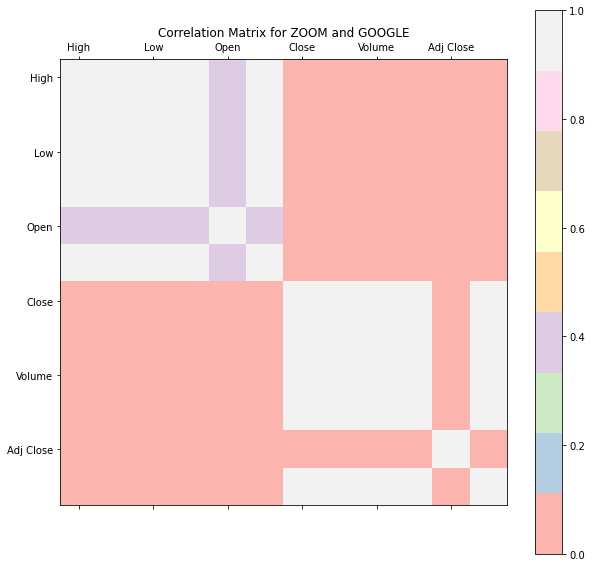

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


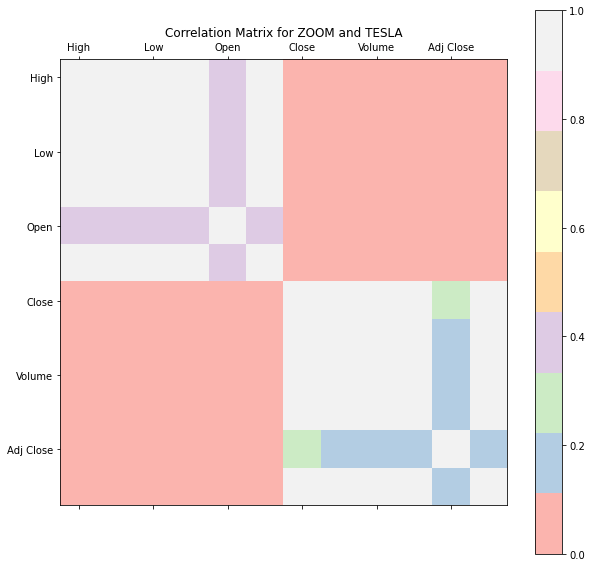

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


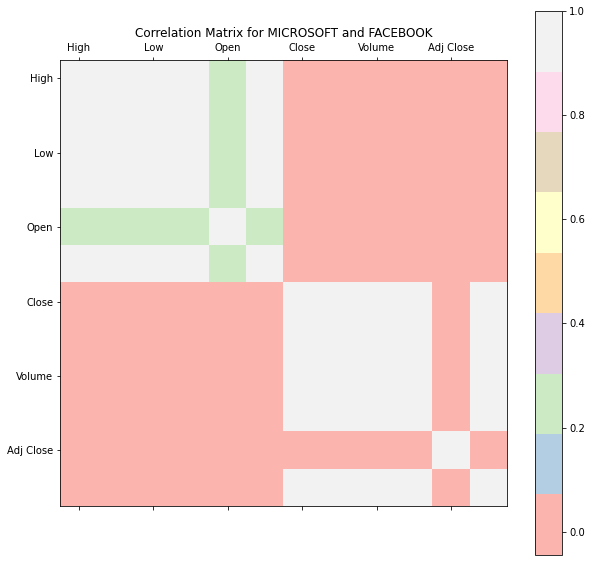

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


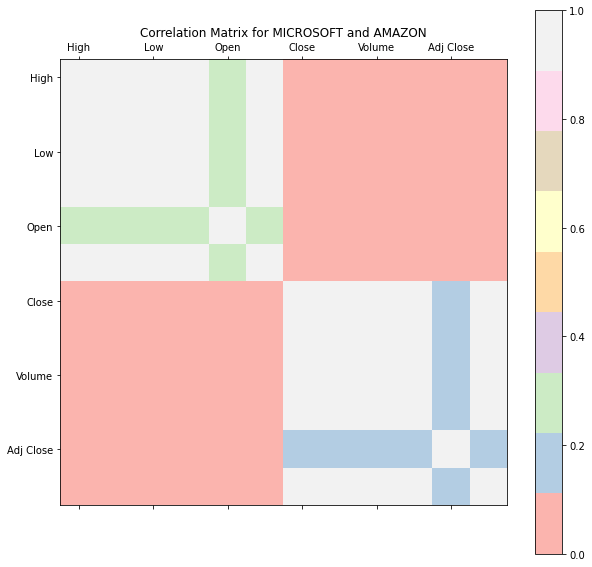

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


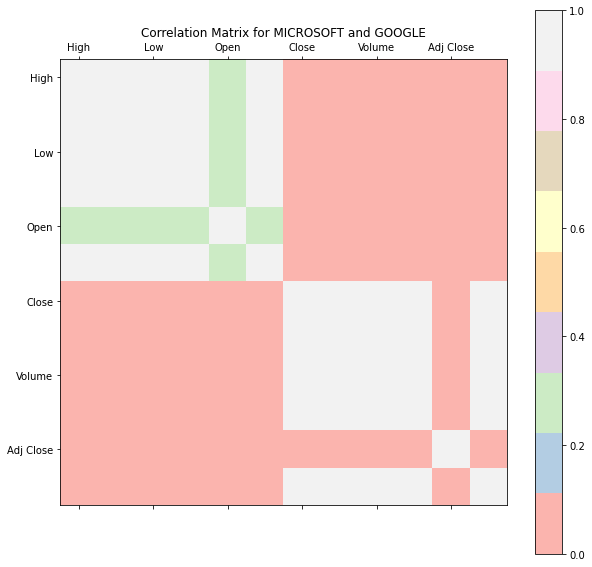

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


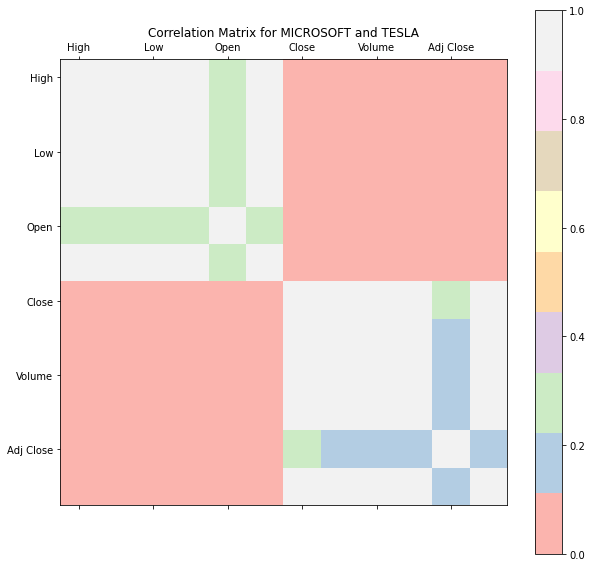

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


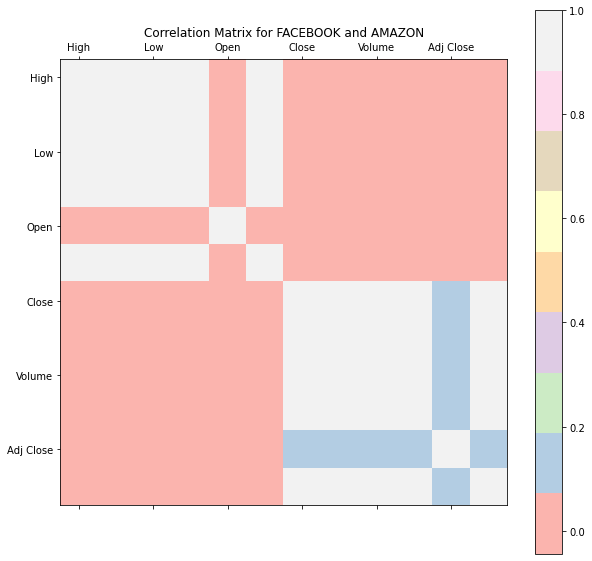

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


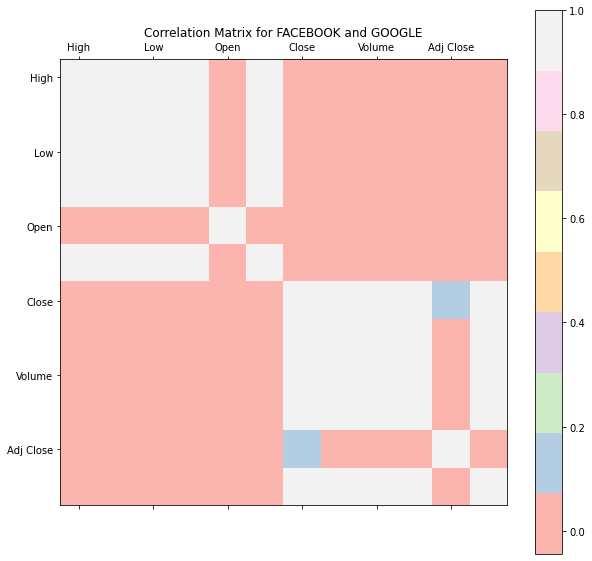

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


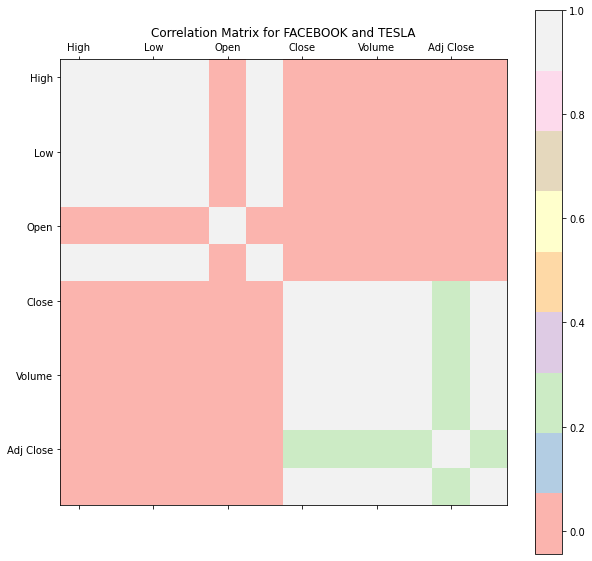

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


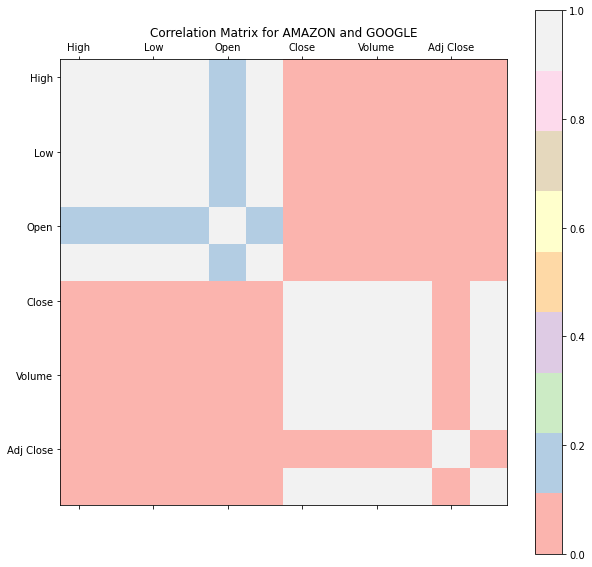

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


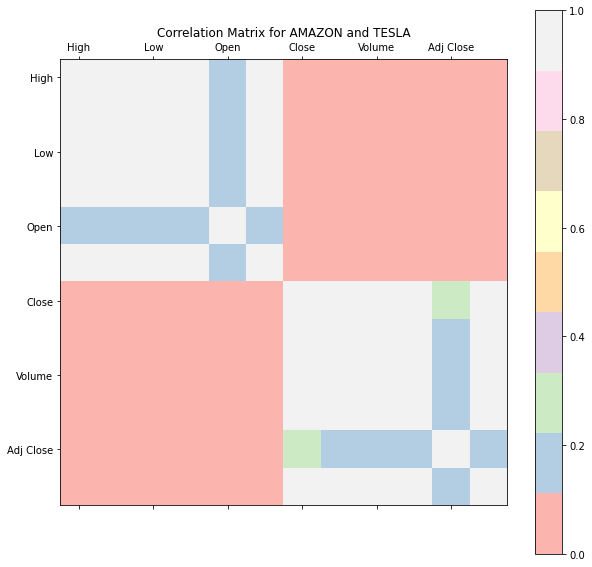

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'High_2', 'Low_2', 'Open_2', 'Close_2', 'Volume_2', 'Adj Close_2']


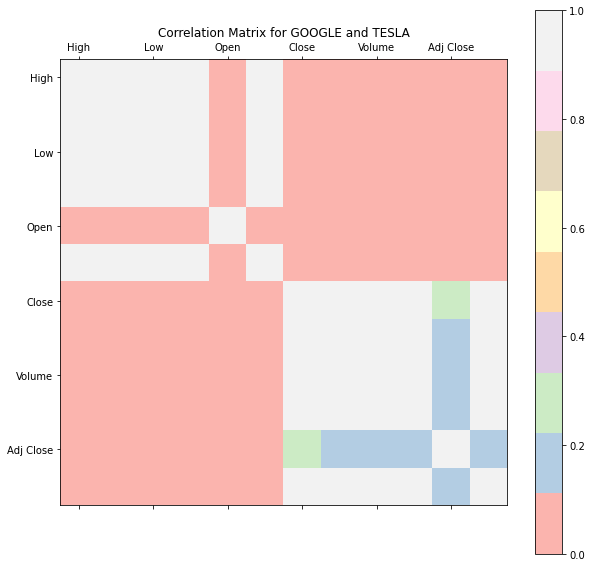

['ret_AMAZON', 'ret_APPLE', 'ret_FACEBOOK', 'ret_GOOGLE', 'ret_MICROSOFT', 'ret_TESLA']


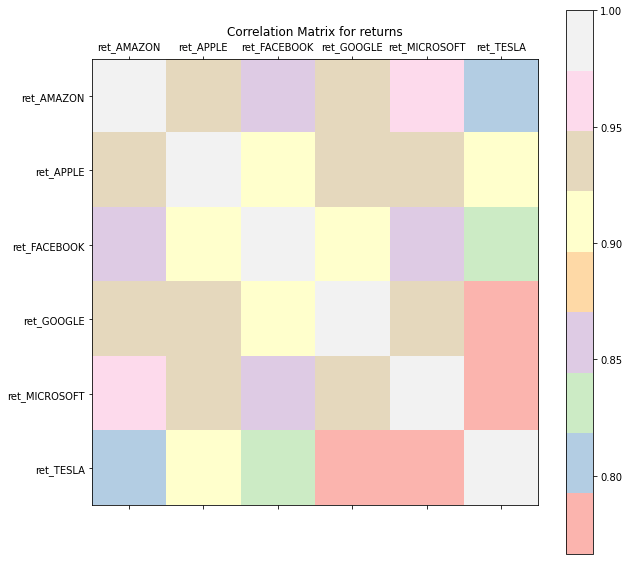

In [89]:
main_visualization()